In [266]:



import pandas as pd
import numpy as np
import gzip
import os
from datetime import datetime
from datetime import timedelta 
import pandas as pd
import calendar
import numpy as np
import glob
import sys
import datetime 

import re
import os
import quantstats as qs
import time

import matplotlib.pyplot as plt

import nest_asyncio # install this package to avoid running in loop

import urllib

import pandas_market_calendars as mcal

import pandas_ta as pta

qs.extend_pandas()
import warnings

# Filter depreciation warnings from pandas regarding the append method
warnings.filterwarnings('ignore', category=FutureWarning, message=".*append.*")


from concurrent.futures import ThreadPoolExecutor

import talib


import sys
sys.path.append(r'C:\Users\Administrator\Desktop\Indian_backtester_python')

from strategy_functions import *

from fetchHistData import *

sys.path.append(r"C:\Users\Administrator\Desktop\Repos\Trade_log_equity")
from Process_trade_log_equity import *   # Import the module



sec_cons_path = r"C:\Users\Administrator\Desktop\Data\Sectorial_indices_constituents_Nifty"





strategy_name = "Sector_ranking_long_intraday_2"


#=== Folder to store EC and trade stats
base_folder = r"C:\Users\Administrator\Documents\ES's and trade_stats_figures"

# Create a folder for the strategy_name if it doesn't exist
strategy_folder = os.path.join(base_folder, strategy_name)
if not os.path.exists(strategy_folder):
    os.makedirs(strategy_folder)

    
    
# Create the full path to the output file. this file contains all the trades

output_all_trades_file = os.path.join(strategy_folder, f"All_trades_{strategy_name}.csv")
trade_html_file = os.path.join(strategy_folder, f"Trade_stats_{strategy_name}.html")    
    

#=== location to store the trade dataframe for debug

base_folder_df = r"C:\Users\Administrator\Documents\strategy_logs"
df_folder = os.path.join(base_folder_df, strategy_name)
if not os.path.exists(df_folder):
    os.makedirs(df_folder)

#----- symbol_wise_trades 

trades_folder = r"C:\Users\Administrator\Documents\symbol_wise_trades"
trades_strategy_folder = os.path.join(trades_folder, strategy_name)
if not os.path.exists(trades_strategy_folder):
    print("\n Making folder for symbol wise trades of strategy" , trades_strategy_folder)
    os.makedirs(trades_strategy_folder)


#--- Input file with 15 min data

nifty_sectorial_indices = [
    "Nifty Auto.csv",
    "Nifty Commodities.csv",
    "Nifty Energy.csv",
    "Nifty Financial Services.csv",
    "Nifty FMCG.csv",
    "Nifty India Consumption.csv",
    "Nifty Infrastructure.csv",
    "Nifty IT.csv",
    "Nifty Media.csv",
    "Nifty Metal.csv",
    "Nifty Pharma.csv",
    "Nifty Private Bank.csv",
    "Nifty PSE.csv",
    "Nifty PSU Bank.csv",
    "Nifty Realty.csv",
    "Nifty Oil and Gas.csv",
    "Nifty CPSE.csv","Nifty Infra.csv" , "Nifty 50.csv"
    
]

print(len(nifty_sectorial_indices))
nifty_sectorial_indices_name = [name.split('.')[0] for name in nifty_sectorial_indices]


19


In [2]:

def find_slope_and_prediction(df, column='Close', window=21):
    
    def calc_slope_intercept(y):
        if len(y) < window:
            return np.nan, np.nan
        x = np.arange(len(y))
        sum_x = np.sum(x)
        sum_y = np.sum(y)
        sum_x2 = np.sum(x**2)
        sum_xy = np.sum(x*y)
        N = len(x)

        # Calculate slope and intercept
        slope = (N * sum_xy - sum_x * sum_y) / (N * sum_x2 - sum_x**2)
        intercept = (sum_y - slope * sum_x) / N
        return slope, intercept

    # Apply the function over a rolling window and extract results
    results = df[column].rolling(window=window).apply(
        lambda y: calc_slope_intercept(y)[0], raw=True
    )

    slopes = results
    intercepts = df[column].rolling(window=window).apply(
        lambda y: calc_slope_intercept(y)[1], raw=True
    )

    # Calculate predicted value for the last point in each window
    predictions = slopes * (window - 1) + intercepts

    return slopes, predictions

# Example usage
# slopes, predictions = find_slope_and_prediction(df, 'Close', 21)

def my_ATR(df, length=14 , highcol='High' , lowcol='Low' , closecol='Close'):
    
    
     
    """
    Finds the ATR using the basic Simple moving average 
    
    Prerequisites
    
    Parameters:
    df =  (pandas.Dataframe): A pandas dataframe with OHLC and datetime as index
    length = (number): period for which to calculate ATR 
    
    Returns:
    ATR values
    
    """
    
    
    
    if df is None or length <= 0 or len(df) < length:
        print("Dataframe is very small or too large value of input period\n")
        return []
    
    # Calculate True Range
    high = df[highcol].values
    low = df[lowcol].values
    close = df[closecol].shift(1).values
    tr = np.maximum(high - low, high - close, close - low)
    
    # Calculate ATR
    atr = np.empty_like(tr)
    atr[:length] = np.nan
    atr[length-1] = tr[1:length].mean()
    for i in range(length, len(df)):
        atr[i] = (atr[i-1]*(length-1) + tr[i]) / float(length)

    return atr


def bars_since_condition(df, column):
    # Calculate the cumulative sum which resets at each '1' to create group identifiers
    group_ids = (df[column] == 1).cumsum()
    
    # Use 'cumcount' to count the number of occurrences since the last reset, adding 1 to start from 1
    bars_since = df.groupby(group_ids).cumcount() 
    
    # Wherever the condition is true, reset 'bars_since' to 1
    return bars_since.where(df[column] == 0, 1)


#== x-min VWAP



def get_x_day_close(df, n, column='Close'):
    """
    Get the previous close of the last n known dates for each row in the DataFrame.

    n>=1
    """
    df = df.copy()
    df['Date'] = df.index.normalize()
    unique_dates = df['Date'].unique()

    # Create a dictionary to store the x_day_close for each date
    x_day_close_dict = {}

    for i, current_date in enumerate(unique_dates):
        # Find the start date index such that the difference in known dates is at least n days
        start_date_index = i - n
        if start_date_index < 0:
            start_date_index = 0

        start_date = unique_dates[start_date_index]
        mask = (df['Date'] < current_date) & (df['Date'] >= start_date)

        # Get the last row within the masked data (assuming chronological order)
        last_row = df.loc[mask].iloc[-1]

        # Access the close price from the last row
        x_day_close_dict[current_date] = last_row[column]

    # Apply the x_day_close values from the dictionary to the DataFrame
    x_day_close = df['Date'].map(x_day_close_dict)

    # Remove the temporary Date column
    # df.drop(columns='Date', inplace=True)

    return x_day_close




        



def upside_beta(df , stock_col = 'Close' , index_col = 'Close_index'):
    
    """
    This function finds the upside beta of a stock in relation to an index.
    Use with daily data
    
    Parameters:
    df (pandas.DataFrame): Input DataFrame with Close and Index close and index as datetime
                             

    Returns:
    pandas.dataframe: returns the upside beta for the entire series

    """
    
    df_copy = df.copy(deep=True)
    
    df_copy['Returns'] = df_copy[stock_col].pct_change()
    df_copy['Index_Returns'] = df_copy[index_col].pct_change()
    

    # Filter periods where index returns are positive
    upside_data = df[df['Index_Returns'] > 0]
    
    
    # Align stock returns with the index upside returns
    aligned_stock_returns_pos = upside_data['Returns']
    

    # Calculate covariance of the stock returns with the market returns during the upside periods
    cov_upside = np.cov(aligned_stock_returns_pos, upside_data['Index_Returns'])[0][1]
    
    # Calculate the variance of the market returns during the upside periods
    var_market_upside = np.var(upside_data['Index_Returns'])
    
    # Upside beta is the covariance divided by the market variance
    upside_beta = cov_upside / var_market_upside

    return upside_beta


def downside_beta(df , stock_col = 'Close' , index_col = 'Close_index'):
    
     
    """
    This function finds the upside beta of a stock in relation to an index.
    Use with daily data
    
    Parameters:
    df (pandas.DataFrame): Input DataFrame with Close and Index close and index as datetime
                             

    Returns:
    pandas.dataframe: returns the upside beta for the entire series

    """
    
    
    df_copy = df.copy(deep=True)
    
    df_copy['Returns'] = df[stock_col].pct_change()
    df_copy['Index_Returns'] = df[index_col].pct_change()
    

    # Filter periods where index returns are positive
    downside_data = df_copy[df_copy['Index_Returns'] < 0]
    
    
    # Align stock returns with the index upside returns
    aligned_stock_returns_pos = downside_data['Returns']
    

    # Calculate covariance of the stock returns with the market returns during the upside periods
    cov_dnside = np.cov(aligned_stock_returns_pos, downside_data['Index_Returns'])[0][1]
    
    # Calculate the variance of the market returns during the upside periods
    var_market_dnside = np.var(downside_data['Index_Returns'])
    
    # Upside beta is the covariance divided by the market variance
    downside_beta = cov_dnside / var_market_dnside

    return downside_beta
    
    

def calculate_rolling_beta(df, window , stock_col = 'Close' , index_col = 'Close_index'):
    
    # Calculate daily returns
    
    #--- but u need the daily 
    
    
    
    df_copy = df.copy(deep=True)
    
    df['Stock_Returns'] = df[stock_col].pct_change()
    df['Index_Returns'] = df[index_col].pct_change()
    
    # Calculate rolling covariance of stock returns with index returns
    rolling_cov = df['Stock_Returns'].rolling(window=window).cov(df['Index_Returns'])
    
    # Calculate rolling variance of index returns
    rolling_var = df['Index_Returns'].rolling(window=window).var()
    
    # Rolling beta is the rolling covariance divided by the rolling variance
    rolling_beta = rolling_cov / rolling_var
    
    return rolling_beta
    
    

def ATR_multi_timeframe(df , timeframe='1D' , length=3 , opencol = 'Open' , highcol='High' , lowcol = 'Low' , closecol='Close' , volcol='Volume'  ,  mamode='RMA'  , talib=True  , percent=False):


    import pandas as pd
    import pandas_ta as pta

    # Assuming 'data' is your DataFrame with daily data
    # Replace 'YourHighColumn', 'YourLowColumn', and 'YourCloseColumn' with actual column names from your data
    daily_data = resample_data(df , highcol = highcol , lowcol = lowcol , closecol = closecol ,opencol = opencol  , volcol = volcol , timeframe = timeframe)
    #print(daily_data)
    
    daily_data.dropna(how='all' , inplace=True)
    
    # Calculate daily ATR for the series
    
    last_3_days_atr = pta.atr(daily_data[highcol], daily_data[lowcol], daily_data[closecol], length=length ,  mamode=mamode  , talib=talib  , percent=percent)
    #print(last_3_days_atr)
    
#     rolling_mean = last_3_days_atr.rolling(window=40 , min_periods=3).mean()
#     rolling_std = last_3_days_atr.rolling(window=40, min_periods=3).std()

#     # Calculate the rolling Z-Score and handle division by zero
#     rolling_z_score = (last_3_days_atr - rolling_mean) / rolling_std

#     # Replace infinities with NaNs if any
#     rolling_z_score.replace([np.inf, -np.inf], np.nan, inplace=True)
    
    
    
    #--- Shift by one to remove future bias
    last_3_days_atr = last_3_days_atr.shift(1)
    #print("\n After shift the last 3 days ATR" ,last_3_days_atr )
    
    last_3_days_atr = last_3_days_atr.reindex(df.index, method='ffill')
    #rolling_z_score = rolling_z_score.reindex(df.index, method='ffill')
 
    return last_3_days_atr
        
    
    
    
    


In [3]:

#=== Code to extract all constituents from the nifty constituents folder and combine them to a list of index name with consituents

sec_cons_list = {}
if os.path.exists(sec_cons_path):
    count = 0 
    
    for fl in glob.glob(sec_cons_path+ "/*.csv"):
        count = count +1
        fname = os.path.basename(fl)
        print("\n === Processing === \n" , fname)
        sec_dfs = pd.read_csv(fl)
        
        # Get the index name (assuming it's in the first row of the DataFrame)
        index_name = sec_dfs.iloc[0, 0]
        
        # Get the constituents (excluding the first row)
        constituents = sec_dfs.iloc[1:, 0].tolist()
        
        # Add to the dictionary
        sec_cons_list[index_name] = constituents
       

print("\n The sector wise constituents are: " , sec_cons_list)


 === Processing === 
 NIFTY 50.csv

 === Processing === 
 NIFTY AUTO.csv

 === Processing === 
 NIFTY BANK.csv

 === Processing === 
 NIFTY COMMODITIES.csv

 === Processing === 
 NIFTY CPSE.csv

 === Processing === 
 NIFTY ENERGY.csv

 === Processing === 
 NIFTY FINANCIAL SERVICES.csv

 === Processing === 
 NIFTY FMCG.csv

 === Processing === 
 NIFTY INFRA.csv

 === Processing === 
 NIFTY IT.csv

 === Processing === 
 NIFTY MEDIA.csv

 === Processing === 
 NIFTY METAL.csv

 === Processing === 
 NIFTY OIL AND GAS.csv

 === Processing === 
 NIFTY PHARMA.csv

 === Processing === 
 NIFTY PSE.csv

 === Processing === 
 NIFTY PSU BANK.csv

 === Processing === 
 NIFTY REALTY.csv

 The sector wise constituents are:  {'NIFTY 50': ['BPCL', 'HDFCLIFE', 'HCLTECH', 'TCS', 'MARUTI', 'ONGC', 'WIPRO', 'SBILIFE', 'INFY', 'LT', 'TATASTEEL', 'UPL', 'BHARTIARTL', 'SBIN', 'TECHM', 'COALINDIA', 'ULTRACEMCO', 'EICHERMOT', 'M&M', 'TATAMOTORS', 'ADANIPORTS', 'DRREDDY', 'HINDALCO', 'ASIANPAINT', 'BAJAJ-AUTO', 

In [ ]:
len(sec_cons_list.keys())

In [4]:
# Create a reverse lookup dictionary
reverse_lookup = {stock: sector for sector, stocks in sec_cons_list.items() for stock in stocks}

# Example usage:
stock_to_find = "DIVISLAB"
sector_name = reverse_lookup.get(stock_to_find)

if sector_name:
    print(f"The sector for {stock_to_find} is {sector_name}")
else:
    print(f"{stock_to_find} not found in any sector.")

The sector for DIVISLAB is NIFTY PHARMA


In [268]:



def process_sectors(df , roc_window=100):
    
    #df['sec_20DMA'] = daily_moving_average(df=df, timeframe='D' , column='Close', periods=20, agg_func='last')
    
    df['fnr_high'] = x_min_close(df=df , column='Close' , start = '9:15',end='9:45')
    
    df['todayo'] = df.Open.groupby(df.index.date).first().reindex(df.index.date).values
    
    df['prevdayc'] = df['Close'].groupby(df.index.date).last().shift().reindex(df.index.date).values
    
    df['prevdayo'] = df['Open'].groupby(df.index.date).first().shift().reindex(df.index.date).values
    
    #df['sec_50DMA'] = daily_moving_average(df=df, timeframe='D' , column='Close_index', periods=50, agg_func='last')
    #df['super'] = supertrend(highcol=df['High_index'] ,lowcol=df['Low_index'] , closecol=df['Close_index'] , length=7 ,multiplier=3)
    
        # Calculate the rolling rate of change (ROC)
    #df['ROC'] = df['Close_index'].pct_change(periods=roc_window) * 100
    


    return df


In [7]:
sectorial_mapping = {'NIFTY50': 'Nifty50',
 'NIFTYNE50': 'NiftyNext50',
 'CNX200': 'Nifty200',
 'CNX500': 'Nifty500',
 'NIFTYMID50': 'NiftyMidcap50',
 'CNXAUTO': 'NiftyAuto',
 'BANKNIFTY': 'NiftyBank',
 'CNXNRG': 'NiftyEnergy',
 'CNXFMCG': 'NiftyFMCG',
 'NIFTYIT': 'NiftyIT',
 'CNXMED': 'NiftyMedia',
 'CNXMET': 'NiftyMetal',
 'CNXPHRM': 'NiftyPharma',
 'CNXPSBK': 'NiftyPSUBank',
 'CNXREAL': 'NiftyRealty',
 'CNXCON': 'NiftyIndiaConsumption',
 'CNXCMD': 'NiftyCommodities',
 'CNXDIV': 'NiftyDividendOpportunities50',
 'NIFTYINFRA': 'NiftyInfrastructure',
 'NIFTYPSE': 'NiftyPSE',
 'CNXSRV': 'NiftyServicesSector',
 'CNXLV': 'NiftyLowVolatility50',
 'CNXAP': 'NiftyAlpha50',
 'CNXHB': 'NiftyHighBeta50',
 'DEFTY': 'Nifty50USD',
 'LIX15': 'Nifty100Liquid15',
 'CPSE': 'NiftyCPSE',
 'NIFTYGS48': 'Nifty4-8yrG-SecIndex',
 'NIFTYGS11': 'Nifty11-15yrG-SecIndex',
 'NIFTYGS15': 'Nifty15yrandaboveG-SecIndex',
 'NIFTYALP': 'NIFTYAlphaQualityValueLow-Volatility30',
 '200QU30': 'NIFTY200Quality30',
 'NIFTY100E': 'Nifty100ESGSectorLeaders',
 'NIFTYHEAL': 'NiftyHealthcareIndex',
 'MIDCAPSEL': 'NiftyMidcapSelect'}

sectorial_mapping = {key: value.replace("Nifty", "Nifty ") for key, value in sectorial_mapping.items()}

print(sectorial_mapping)

manual_sector_to_symbol_mapping = {
    'Nifty Auto': 'CNXAUTO',
    'Nifty Commodities': 'CNXCMD',
    'Nifty Energy': 'CNXNRG',
    'Nifty Financial Services': 'NSEFIN', # No direct match found
    'Nifty FMCG': 'CNXFMCG',
    'Nifty India Consumption': 'CNXCON',
    'Nifty Infrastructure': 'NIFTYINFRA', # Assuming 'Nifty Infrastructure' maps to 'NIFTYINFRA'
    'Nifty IT': 'NIFTYIT',
    'Nifty Media': 'CNXMED',
    'Nifty Metal': 'CNXMET',
    'Nifty Pharma': 'CNXPHRM',
    'Nifty Private Bank': 'N/A', # No direct match found. Might correspond to a subset of 'BANKNIFTY'
    'Nifty PSE': 'NIFTYPSE',
    'Nifty PSU Bank': 'CNXPSBK',
    'Nifty Realty': 'CNXREAL',
    'Nifty Oil and Gas': 'NIFTYOIL', # No direct match found
    'Nifty CPSE': 'CPSE',
    'Nifty Infra': 'NIFTYINFRA', # Assuming 'Nifty Infra' is the same as 'Nifty Infrastructure'
    'Nifty 50': 'NIFTY50',
    'NIFTY BANK': "BANKNIFTY"
    
}

{'NIFTY50': 'Nifty 50', 'NIFTYNE50': 'Nifty Next50', 'CNX200': 'Nifty 200', 'CNX500': 'Nifty 500', 'NIFTYMID50': 'Nifty Midcap50', 'CNXAUTO': 'Nifty Auto', 'BANKNIFTY': 'Nifty Bank', 'CNXNRG': 'Nifty Energy', 'CNXFMCG': 'Nifty FMCG', 'NIFTYIT': 'Nifty IT', 'CNXMED': 'Nifty Media', 'CNXMET': 'Nifty Metal', 'CNXPHRM': 'Nifty Pharma', 'CNXPSBK': 'Nifty PSUBank', 'CNXREAL': 'Nifty Realty', 'CNXCON': 'Nifty IndiaConsumption', 'CNXCMD': 'Nifty Commodities', 'CNXDIV': 'Nifty DividendOpportunities50', 'NIFTYINFRA': 'Nifty Infrastructure', 'NIFTYPSE': 'Nifty PSE', 'CNXSRV': 'Nifty ServicesSector', 'CNXLV': 'Nifty LowVolatility50', 'CNXAP': 'Nifty Alpha50', 'CNXHB': 'Nifty HighBeta50', 'DEFTY': 'Nifty 50USD', 'LIX15': 'Nifty 100Liquid15', 'CPSE': 'Nifty CPSE', 'NIFTYGS48': 'Nifty 4-8yrG-SecIndex', 'NIFTYGS11': 'Nifty 11-15yrG-SecIndex', 'NIFTYGS15': 'Nifty 15yrandaboveG-SecIndex', 'NIFTYALP': 'NIFTYAlphaQualityValueLow-Volatility30', '200QU30': 'NIFTY200Quality30', 'NIFTY100E': 'Nifty 100ESGSect

In [ ]:
manual_sector_to_symbol_mapping.values()

In [269]:


#=== code to extract OHLC data for all sectorial indices

indices_fol = r"C:\Users\Administrator\Desktop\Data\Nifty_indices_historical_intraday"
sec_df = {}

count = 0


if os.path.exists(indices_fol):
        
    for fl in glob.glob(indices_fol+ "/*.csv"):
        count = count +1
        fname = os.path.basename(fl).split('.')[0]
        
        print("\n === Processing === \n" , fname)
        
        desc = sectorial_mapping.get(fname)
        print("\n found as : " , desc )
        if fname in manual_sector_to_symbol_mapping.values():
            
            
                        # One-liner to find the key for a given value
            key_for_value = {v: k for k, v in manual_sector_to_symbol_mapping.items()}[fname]
            
            print("\n sector_name: " ,key_for_value)
        
            df = pd.read_csv(fl)
            
            df['Symbol'] = key_for_value
            
            df.columns = [col.capitalize() for col in df.columns]

            
            print(df.columns)
            df = convert_datetime(df , column_name='Date' , is_index=0)
            df.set_index('Date' , inplace=True)
            
            df = process_sectors(df , roc_window=20)
            
            
            df['rank_param'] = df['prevdayc']/df['prevdayo']
                        
            df = df[df.index.year>=2020]
            print("\n " , df)
            
                        
            
            # #df = add_time_to_column_or_index(df , specific_time='09:15')
            
           
            # Get the sector name and use it as the key in the dictionary
            sector_name = df['Symbol'].iloc[0]  # You can adjust this based on your data
            
            #sector_name = str(sector_name).upper()
            
            sec_df[sector_name] = df
            



 === Processing === 
 200QU30

 found as :  NIFTY200Quality30

 === Processing === 
 BANKNIFTY

 found as :  Nifty Bank

 sector_name:  NIFTY BANK
Index(['Date', 'Open', 'High', 'Low', 'Close', 'Symbol'], dtype='object')

                          Open     High      Low    Close      Symbol  fnr_high  \
Date                                                                            
2020-01-02 09:15:00 32139.50 32218.50 32135.50 32218.50  NIFTY BANK  32218.50   
2020-01-02 09:20:00 32222.00 32236.00 32210.50 32216.00  NIFTY BANK  32216.00   
2020-01-02 09:25:00 32217.50 32238.50 32214.00 32232.00  NIFTY BANK  32232.00   
2020-01-02 09:30:00 32233.50 32255.50 32227.50 32241.00  NIFTY BANK  32241.00   
2020-01-02 09:35:00 32240.00 32245.50 32182.00 32193.50  NIFTY BANK  32193.50   
...                      ...      ...      ...      ...         ...       ...   
2024-04-08 15:05:00 48581.50 48591.00 48548.00 48583.50  NIFTY BANK  48521.00   
2024-04-08 15:10:00 48586.00 48614.50 48568.00

In [241]:
import pandas as pd


def create_tradelog2(df, symbol):
    
    print("\nCreating trade log for", symbol)
    
    if df.empty:
        print("DataFrame is empty. No data to process.")
        return pd.DataFrame()
    df['position_change'] = df[f'{symbol}_position'].diff()
    
        # Construct column names dynamically
    columns = [
        f'{symbol}bar_count', f'{symbol}_position',  'position_change' , f'{symbol}_ret', f'{symbol}_Close' , f'{symbol}_order']

    # Now filter the DataFrame to include only the columns for this symbol
    df = df[columns]
    
    
    # Assuming 'bar_count_col' and other columns are defined as per your data
    bar_count_col = f'{symbol}bar_count'

    # Check if the essential column exists in the DataFrame
    if bar_count_col not in df.columns:
        print(f"Missing essential column: {bar_count_col}")
        return pd.DataFrame()
    
    # Identifying the end of a trade
    df['trade_end'] = (df[bar_count_col].shift(-1) < df[bar_count_col]) | (df[bar_count_col].shift(-1) == 0) | df[bar_count_col].eq(0)

    # Creating 'trade_start' to identify the start of a trade
    df['trade_start'] = df['trade_end'].shift(1).fillna(False) | df[bar_count_col].eq(1)
    df['trade_start'] = df['trade_start'].astype(int)

    # Generating 'trade_id' for each trade
    df['trade_id'] = df['trade_start'].cumsum()

    # Filtering out rows not part of any trade (i.e., before any trade has started)
    df = df[df['trade_id'] > 0]
    
    # Processing each trade to gather trade details
    trades_info = []
    for trade_id, trade_group in df.groupby('trade_id'):
        if trade_group.empty or trade_group[bar_count_col].max() == 0:
            continue  # Skip empty trades or trades without bar counts
        
        #print("\n Individual trade found as " , trade_group)
        
        #print("\n Exit price: " , trade_group.iloc[-1][f'{symbol}_Close'])
        positionn = trade_group[f'{symbol}_position'].iloc[0]
        side = 'long' if positionn == 1 else 'Short' if positionn == -1 else 'flat'
        
        trade_details = {
            'Symbol': symbol,
            'Side': side,
            'Trade ID': trade_id,
            'Start Time': trade_group.index[0],
            'End Time': trade_group.index[-1],
            'Entry Price': trade_group.iloc[0][f'{symbol}_Close'],  # Assuming 'Close' is the close price column
            'Exit Price': trade_group.iloc[-1][f'{symbol}_Close'],  # Modify as per your DataFrame's column names
            # Include other details as needed
        }
        trades_info.append(trade_details)
    
    # Converting the trades information into a DataFrame
    trade_summary_df = pd.DataFrame(trades_info)
    return trade_summary_df

# Replace 'your_symbol' and 'Close' with actual column names as per your DataFrame
# Ensure your DataFrame 'df' is indexed appropriately (e.g., datetime index) and contains the necessary columns


In [270]:
import pandas as pd

def rank_sectors_by_param(sec_df, rank_col='rank_param', ascending_rank=False):
    """
    Ranks sectors (a dict of DataFrames) based on a specified parameter across multiple DataFrames stored in a dictionary.
    Each DataFrame represents a sector, and the function ranks these sectors within each row based on the values of a specified column.
    
    Parameters:
    - sec_df: Dictionary of DataFrames, where each key is a sector name and each value is a DataFrame containing sector data.
    - rank_col: The name of the column in each DataFrame to rank the sectors by. Default is 'rank_param'.
    - ascending_rank: Boolean indicating how the rankings should be ordered. 
                      If False (default), higher values receive a lower rank (better). 
                      If True, lower values receive a lower rank (better).
    
    Returns:
    - A dictionary of DataFrames, where each DataFrame has been updated to include a new column 'col_rank' 
      that contains the rankings of sectors for each row based on the specified column.
    
    Note:
    - ascending=True means that lower values are assigned better (lower) ranks.
    - ascending=False means that higher values are assigned better (lower) ranks.
    """
    
    # Create a DataFrame from the sec_df dictionary, extracting the specified rank_col from each sector's DataFrame
    rank_dataframe = pd.DataFrame({key: df[rank_col] for key, df in sec_df.items()})
    
    # Rank the sectors within each row based on the specified column. 
    # 'method=first' ensures that ties are broken based on order in the DataFrame.
    rankings = rank_dataframe.rank(axis=1, method='average', ascending= ascending_rank)
    
    # Update the original DataFrames with their rankings
    for key in sec_df.keys():
        sec_df[key]['col_rank'] = rankings[key]
    
    # Return the updated dictionary of DataFrames
    return sec_df

# Example usage:
# Assuming sec_df is your dictionary of DataFrames where each DataFrame has a column named 'rank_param'
# updated_sec_df = rank_sectors_by_param(sec_df, 'rank_param', False)
# for key, df in updated_sec_df.items():
#     print(f"{key} DataFrame with rankings:")
#     print(df)


In [271]:
sec_df = rank_sectors_by_param(sec_df, rank_col='rank_param', ascending_rank=False)


In [272]:
sec_df['NIFTY BANK']

,Open,High,Low,Close,Symbol,fnr_high,todayo,prevdayc,prevdayo,rank_param,col_rank
Date,,,,,,,,,,,
2020-01-02 09:15:00,32139.50,32218.50,32135.50,32218.50,NIFTY BANK,32218.50,32139.50,32179.50,32343.50,0.99,9.00
2020-01-02 09:20:00,32222.00,32236.00,32210.50,32216.00,NIFTY BANK,32216.00,32139.50,32179.50,32343.50,0.99,9.00
2020-01-02 09:25:00,32217.50,32238.50,32214.00,32232.00,NIFTY BANK,32232.00,32139.50,32179.50,32343.50,0.99,9.00
2020-01-02 09:30:00,32233.50,32255.50,32227.50,32241.00,NIFTY BANK,32241.00,32139.50,32179.50,32343.50,0.99,9.00
2020-01-02 09:35:00,32240.00,32245.50,32182.00,32193.50,NIFTY BANK,32193.50,32139.50,32179.50,32343.50,0.99,9.00
...,...,...,...,...,...,...,...,...,...,...,...
2024-04-08 15:05:00,48581.50,48591.00,48548.00,48583.50,NIFTY BANK,48521.00,48562.00,48521.00,48079.50,1.01,3.00
2024-04-08 15:10:00,48586.00,48614.50,48568.00,48606.00,NIFTY BANK,48521.00,48562.00,48521.00,48079.50,1.01,3.00
2024-04-08 15:15:00,48607.00,48608.50,48578.50,48595.00,NIFTY BANK,48521.00,48562.00,48521.00,48079.50,1.01,3.00


In [280]:

def process_sector_df(df):
        
    df = df.sort_index()
    
    stk = df['Symbol'].iloc[0]
    
    #-- Change back the symbols
    
    df['first_hr_high'] =  x_min_high(df , 'High' , start='09:15' , end='09:45' )
   # df['cval'] = x_min_cum_vol(df , 'Volume' , start='09:30' , end=rank_time)
    df['x_day_low'] = get_x_day_low(df, n=10 , column='Close')
    #df['x_day_high'] = get_x_day_high(df , n=10 , column='Close')
   
    #f'{stk}_f'{stk}_Close''
    
    #df['5drng'] = get_x_day_range(df , n=5, high_col='Close' , low_col='Close')
    
    df['20DMA'] = daily_moving_average(df , 'D' , 'Close' , periods=20 , agg_func='last')
    
    #df[fname+'_ratio'] = df['cval']/df['D_Volume_moving_average']
        
    df['todayo'] = df['Open'].groupby(df.index.date).first().reindex(df.index.date).values
    df['prevdayc'] = df['Close'].groupby(df.index.date).last().shift().reindex(df.index.date).values
    df['secdayc'] = df['Close'].groupby(df.index.date).last().shift().reindex(df.index.date).values
    
    #df['ratio_co'] = df[''Close'']/(df[['todayo', 'prevdayc']].max(axis=1))
    df['prevdayl'] = df['Low'].groupby(df.index.date).min().shift().reindex(df.index.date).values
    df['prevdayh'] = df['High'].groupby(df.index.date).max().shift().reindex(df.index.date).values
    df['prevdayo'] = df['Open'].groupby(df.index.date).first().shift().reindex(df.index.date).values
    
    df['EOD'] = df.index.to_series().dt.date != df.index.to_series().shift(-1).dt.date
    #df['slope'] = find_slope_and_prediction(df , 'Low' , window=100)[0]
    #df['vwap'] = intraday_vwap(df)
    
    #df['ATR'] = ATR(highcol=df['High'] , lowcol=df['Low'] , 'Close'col=df['Close'] , length=7 , percent=False , mamode='WMA')
#     df['ATR_zc'] = z_score_price(df ,  'ATR' , window_size=3)
#     df['z_score'] = z_score_price(df , column='High' , window_size=13)
    
    
    #=== Find ATR and z-score of ATR
#     df['ATR'] = ATR(highcol=df['High'] , lowcol=df['Low'] , 'Close'col=df[''Close''] , length=14 , percent=False , mamode='WMA')
#     df['ATR_zc'] = z_score_price(df ,  'ATR' , window_size=50)
    
    #df['last_trough'] = find_trough_multi_tf(df , column='Low' , threshold=0.25, distance=5 , timeframe='1D')
        
    #df , close_col = 'Close' , low_col = 'Low' , high_col='High')
    df = pivot_points_classic(df=df , close_col='Close' , low_col = 'Low' , high_col='High')
    
    df['todayl'] = intraday_low(df=df , low_col='Low' , agg_func='min')
    df['todayh'] = intraday_high(df=df , high_col='High' , agg_func='max')
    #df['daily_RSI'] = rsi_timeframe(df ,period=7 , timeframe='1D' )
    #df['zc_ROC'] = daily_ROC(df , column=''Close'' , ROC_period=3 , z_score_period=40)
    df = df[(df.index.year>=2020) & (df.index.year<2024)]
    
    
    condition1 = df.index.time>=datetime.time(10 , 5) 
    
    
    condition6 = df['todayo']>df["prevdayc"]*0.995
    #condition10 = df['indClose']<df['indtodayo']*1.02
    condition11 = df['prevdayc']>df['prevdayo']*0.98
    condition7 = df['Low']>df["todayl"]*1.002
    condition8 = df['rank_param']>1
    condition9 = df["col_rank"]<7
    
    df['signal'] = condition1 & condition8 & condition9 & condition11 & condition7 
        
    #=== For short signals
    
    condition21 = df.index.time>=datetime.time(9 , 45)
    condition22 = df['rank_param']<1
    condition23 = df["col_rank"]>9
    condition24 = df['prevdayc']<df['prevdayo']*1.02
    
    df[f'{stk}_short_signal'] = condition21 & condition22 & condition23 & condition24
    
    
    ofol = df_folder
    ofil = os.path.join(ofol , f'{stk}.csv')
    #print(ofil)
    df.to_csv(ofil)
    
           

    # Compute the final result and return it as a pandas DataFrame
    return df 
    


In [281]:
def process_signal_sector(df, side=1 , intra_Exit=0 , n_day_Exit=2 ):
    
    symbol = df['Symbol'].iloc[0]
    
    #================================================================================================
    if symbol is None:
        raise ValueError("Symbol must be provided")
    
    print("\n Processing signals of", symbol )
    
    log = []
    bar_counts = [0] * len(df)
    positions = [0]* len(df)
    position = 0
    day_count = 0
    entry_price = 0 
    exit_price = 0 
    ordern = 0 
    orders = [0]*len(df)
    highest_high = 0 
    # Compute date changes using diff()
    #df['date_changed'] = df.index.to_series().diff().dt.days != 0
    
        # Ensure your index is a DateTimeIndex and sorted.
    df['date_changed'] = df.index.to_series().dt.date != df.index.to_series().shift(1).dt.date
    
    #================================================================================================
            
    for i in range(len(df)):
        
        row = df.iloc[i]
        current_date = df.index[i].date()
        bar_time = df.index[i].time()
                
       
               # If in a position, increment the bar count
        if position != 0:
            # Increment bar_count
            bar_counts[i] = bar_counts[i-1] + 1
            # Check if the date has changed and increment day_count if it has
            if row['date_changed']:
                day_count += 1
        else:
            # Reset counts when not in position
            bar_counts[i] = 0
            ordern = 0 
            day_count = 0  # Reset day_count here if that's the intended logic
            entry_price = 0
       
        
        # ---- HIghest high and lowest low after in position....
        
        highest_high = row["Close"] if position != 0 and row['Close'] > highest_high else highest_high if position > 0 else 0
        lowest_along = row['Close'] if position != 0 and row['Close'] < lowest_along else lowest_along if position > 0 else 0
        
        # and df['Close'][i]<df['R2'][i-1] not helping
        
        if df['signal'][i]==1 and df['High'][i]>df['first_hr_high'][i-1]*0.999 and position == 0 and df['Close'][i]>df['prevdayl'][i-1]*1.001 and df['Close'][i]>df['S1'][i-1] :
            # Determine if it's a long or short entry
            if side > 0:
                position = 1
                entry_price = row['Close']
                bar_counts[i]+=1
                ordern = 1                 
                print("\n Position taken long at : " , df.index[i] , "- entry- :  " , entry_price , "rank: " , df["col_rank"][i] )
                #print("\n " , "Position details:  prevdayl : " , df[f'{stk}_prevdayl'][i] , "10dma " , df[f'{stk}_10dma'][i])
                log.append((df.index[i], symbol, position , entry_price , ordern))
                #print("\n" , df['5drng'][i])
        
        
#         if df[f'{stk}_short_signal'][i]==1 and position == 0 :
        
#             if side == 2:
                
#                 position = -1
#                 entry_price = row['Close']
#                 ordern = -1 
#                 print("\n Position taken Short at : " , df.index[i] , "-- entry Price - :  " , entry_price , ": position: " , position)
#                 log.append((df.index[i], symbol, position , entry_price, ordern))
        
        # ------- short Stop loss
        
        if position ==-1 and row['Close'] > max(df['todayo'][i]*1.005 ,entry_price*1.015)  and bar_counts[i]>=1:
            
            print("\n Short Position Hit stop " , df.index[i] , "at: ", row['Close'], " - Today open: " , df['todayo'][i]  )
            
            position = 0
            
            exit_price = row['Close']
            ordern = -13
            log.append((df.index[i], symbol, position , exit_price, ordern))
        
        # ==== Long stop loss
        
        if position == 1 and row['Close'] < min(df['todayo'][i]*1.001 ,entry_price*0.985)  and bar_counts[i]>1:
            
            #print("\n Position Hit stop " , df.index[i] , "at: ", row['Close'], " - Today open: " ,df[f'{stk}_todayo'][i]  )
            
            position = 0
            #bar_counts[i] = 0
            exit_price = row['Close']
            ordern = 13
            log.append((df.index[i], symbol, position , exit_price, ordern))
        
        # if position == 1 and row['Close'] <min(df[f'{stk}_Open'][i]*0.995 ,df[f'{stk}_prevdayl'][i])  and bar_counts[i]>1:
            
        #     print("\n Big loss " , df.index[i] , "at: ", row['Close'], " - prev day low: " ,df[f'{stk}_prevdayl'][i]  )
            
        #     position = 0
        #     bar_counts[i] = 0
        #     exit_price = row['Close']
        #     ordern = 13
        #     log.append((df.index[i], symbol, position , exit_price, ordern))
        
            
#         if position == 1 and df['indClose'][i]< min(df['indprevdayc'][i]*0.98 ,df["nif_flow"][i]*0.99)  and bar_counts[i]>12:
            
#             print("\n Index Hit stop " , df.index[i] , "at: index close ", df['indClose'][i], " - prevdayc: " ,df['indprevdayc'][i]  )
#             position = 0
#             bar_counts[i] = 0
#             exit_price = row['Close']
#             ordern = 13
#             log.append((df.index[i], symbol, position , exit_price, ordern))


        
        # ---- End of Day Exit condition based on parameter intra_exit
        
        # ---- print("position " ,position , df['bar_count'][i])
        
        if position != 0 and intra_Exit==1 and df.index[i].time()>= datetime.time(15, 1) and bar_counts[i] > 1:
            
            #print("Hi")
            print("\n Position exit EOD  at" , df.index[i] , position , "position at  ", row['Close'] )
            
            position = 0
            
            exit_price = row['Close']
            ordern = 11 
            log.append((df.index[i], symbol, position , exit_price))
        
        
        if position != 0 and intra_Exit==1 and df['EOD'][i]==1 and bar_counts[i]>1:
            
            #print("Hi")
            #print("\n Position exit EOD via code" , df.index[i] , position , "position at  ", row['Close'] )
            
            position = 0
            
            exit_price = row['Close']
            ordern = 11 
            log.append((df.index[i], symbol, position , exit_price))
        
        
        
#         if position != 0 and bar_counts[i]>4 and df['indClose'][i]<df["indOpen"][i-1]*0.985 and df['High'][i]<df['todayh'][i-1]*0.985:
            
#             #print("Hi")
#             #print("\n Nifty bear exit at: " , df.index[i] ,"Nifty high and highest are:  "  ,df['indHigh'][i] , df['ind_todayh'][i-1]  )
            
#             position = 0
#             bar_counts[i] = 0
#             exit_price = row['Close']
#             ordern = 11 
#             log.append((df.index[i], symbol, position , row['Close']))
        
               
                
        if position > 0 and day_count>=1 and df.index[i].time()>= datetime.time(9, 30) and bar_counts[i]>6 and df['todayo'][i]<df['prevdayl'][i]*0.99 and df['Close'][i]<df['Close'][i-1]  :
            print("\n prev day exit down exit EOD long at" , df.index[i] , position , "position at  ", row['Close'] , "Day_count: " , day_count  )
        
            position = 0
           
            exit_price = row['Close']
            ordern = 13
            log.append((df.index[i], symbol, position , row['Close'], ordern))
        
#         if position > 0 and day_count>=1 and bar_counts[i]>3 and df['Close'][i]<df['Open'][i]*0.985  :
#             #print("\n Large bear bar" , df.index[i]  , "Day_count: " , day_count , "close: " , df['Close'][i] , df['Open'][i] )
        
#             position = 0
#             bar_counts[i] = 0
#             exit_price = row['Close']
#             ordern = 13
#             log.append((df.index[i], symbol, position , row['Close'], ordern))
                
        
        if position != 0 and intra_Exit==0 and day_count>=n_day_Exit and bar_counts[i]>1 and df['Close'][i]<df['Close'][i-1]  :
            
            #print("\n Carryforward exit EOD long at" , df.index[i] , position , "position at  ", row['Close'] , "Day_count: " , day_count )
            
            position = 0
            
            exit_price = row['Close']
            ordern = 12
            log.append((df.index[i], symbol, position , row['Close'], ordern))
                
        
        #---- Stop-loss of 3%
        
        if position!=0 and df['todayo'][i]<df['x_day_low'][i] and df['Close'][i]<df['Low'][i-1] and day_count>=1 and df.index[i].time()>=datetime.time(10 , 00):
            
            position = 0
            
            exit_price = row['Close']
            ordern = 12
            log.append((df.index[i], symbol, position , row['Close'], ordern))
            
            print("\nBreakdown opening exit from low:  " , df['x_day_low'][i] ,   " -- open at" , df['todayo'][i])

        
        positions[i] = position
        orders[i] = ordern
  
          #----- reistance exit
        
        if position >0 and df['Close'][i-1]>df['R2'][i-1]*1.01 and df['Close'][i]<df['R2'][i-1]*1.01 and bar_counts[i]>5 and df.index[i].time() >= datetime.time(9, 30):
            
            print("\n Resistance target  " , df.index[i] , "at  ", row['Close'] , " R2 prev: " , df['R2'][i-1]  )
            position = 0
           # bar_counts[i] = 0
            ordern = 16
            log.append((df.index[i], symbol, position , row['Close'], ordern))
    
    
    #print("\n Position at last bar is " , positions[-1]   )
    
    df[symbol+'bar_count'] = bar_counts
    df[symbol+'_order'] = orders
    df[symbol+'_position'] = positions
    
    #== these are bar-by-bar returns when you are in position 
    df[symbol+'_ret'] = np.where(df[symbol+'bar_count']>0 ,  df['Close'].pct_change()*side , 0)
        
    #=== 
    df[symbol+'_Close'] = df['Close']

    trade_log = create_tradelog2(df , symbol=symbol)


#     if( num_entries!=num_exits):

#         print("\n \n Number of entries and exits dont match"  , "Entries: " , num_entries , "----- Exits" , num_exits  )
#trades_strategy_folder 
    # Construct the file path
    file_path = os.path.join(trades_strategy_folder, f"{symbol}.csv")
    trade_log.to_csv(file_path )

        
    
    return df[[symbol+'_Close' , symbol+'_position' ,symbol+'_ret' , symbol+'bar_count', symbol+'_order']] 




In [282]:
def sector_strategy_function(df):
    
    df = process_sector_df(df)
        
    cdf  = process_signal_sector(df ,  side=1 , intra_Exit=0 , n_day_Exit=3)    
    
    return cdf



# Assuming sec_df is a dictionary with keys as sector names and values as dataframes
sector_names = list(sec_df.keys())

# Function to be executed in the thread pool
def process_sector(sector_name):
    return sector_strategy_function(sec_df[sector_name])



num_cores = os.cpu_count()
print("\n Max cores in system : ", num_cores)

#Using ThreadPoolExecutor to parallelize the function execution
with ThreadPoolExecutor(max_workers=num_cores-1) as executor:  # max_workers can be adjusted based on your system
    # Map the function over the sector names, executing in parallel
    results = list(executor.map(process_sector, sector_names))

# Do something with the results, e.g., concatenate them into a single DataFrame
combined_df = pd.concat(results, axis=1, join='outer')

    


 Max cores in system :  4

 Processing signals of NIFTY BANK

 Position taken long at :  2020-01-09 10:15:00 - entry- :   31859.0 rank:  3.0

 Resistance target   2020-01-09 13:40:00 at   32083.0  R2 prev:  31782.166666666668

 Position taken long at :  2020-01-09 13:45:00 - entry- :   32111.5 rank:  3.0

 Resistance target   2020-01-09 14:40:00 at   32058.0  R2 prev:  31782.166666666668

 Position taken long at :  2020-01-09 14:45:00 - entry- :   32067.0 rank:  3.0

 Resistance target   2020-01-09 15:15:00 at   32092.0  R2 prev:  31782.166666666668

 Position taken long at :  2020-01-09 15:20:00 - entry- :   32089.5 rank:  3.0

 Position taken long at :  2020-01-17 10:35:00 - entry- :   31745.0 rank:  6.0

 Position taken long at :  2020-01-24 10:05:00 - entry- :   31150.5 rank:  6.0

 Position taken long at :  2020-02-06 11:50:00 - entry- :   31163.5 rank:  6.0

 Position taken long at :  2020-02-12 10:05:00 - entry- :   31514.0 rank:  5.0

 Position taken long at :  2020-03-16 10:5

C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_34920\3156815680.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['trade_end'] = (df[bar_count_col].shift(-1) < df[bar_count_col]) | (df[bar_count_col].shift(-1) == 0) | df[bar_count_col].eq(0)
C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_34920\3156815680.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['trade_start'] = df['trade_end'].shift(1).fillna(False) | df[bar_count_col].eq(1)
C:\Users\Administrator\AppData\Local\Temp\2\ipyk


 Position taken long at :  2021-03-02 10:05:00 - entry- :   10495.4 rank:  5.0

 Position taken long at :  2021-03-05 10:05:00 - entry- :   10645.65 rank:  5.0

 Position taken long at :  2021-06-03 11:45:00 - entry- :   5187.15 rank:  6.0


C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_34920\3156815680.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['trade_id'] = df['trade_start'].cumsum()



 Position taken long at :  2021-06-14 10:45:00 - entry- :   5257.2 rank:  5.0

 Position taken long at :  2021-04-08 10:05:00 - entry- :   10036.6 rank:  2.0

 Position taken long at :  2021-06-28 10:05:00 - entry- :   5204.0 rank:  6.0

 Position taken long at :  2021-04-23 10:05:00 - entry- :   9632.0 rank:  6.0

 Position taken long at :  2021-07-06 10:05:00 - entry- :   5194.9 rank:  4.0

 Position taken long at :  2021-07-12 10:05:00 - entry- :   5226.0 rank:  3.0

 Position taken long at :  2021-05-06 10:25:00 - entry- :   9783.05 rank:  6.0

 Position taken long at :  2021-07-16 10:15:00 - entry- :   5278.35 rank:  5.0

 Position taken long at :  2021-05-11 10:15:00 - entry- :   9940.2 rank:  5.0

 Position taken long at :  2021-05-18 10:05:00 - entry- :   10132.55 rank:  4.0

 Resistance target   2021-05-18 12:55:00 at   10283.4  R2 prev:  10189.833333333334

 Position taken long at :  2021-05-18 13:00:00 - entry- :   10288.1 rank:  4.0

 Resistance target   2021-05-18 13:40:0

C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_34920\3156815680.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['trade_end'] = (df[bar_count_col].shift(-1) < df[bar_count_col]) | (df[bar_count_col].shift(-1) == 0) | df[bar_count_col].eq(0)
C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_34920\3156815680.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['trade_start'] = df['trade_end'].shift(1).fillna(False) | df[bar_count_col].eq(1)
C:\Users\Administrator\AppData\Local\Temp\2\ipyk


Creating trade log for Nifty Auto


C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_34920\3156815680.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['trade_end'] = (df[bar_count_col].shift(-1) < df[bar_count_col]) | (df[bar_count_col].shift(-1) == 0) | df[bar_count_col].eq(0)
C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_34920\3156815680.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['trade_start'] = df['trade_end'].shift(1).fillna(False) | df[bar_count_col].eq(1)
C:\Users\Administrator\AppData\Local\Temp\2\ipyk


 Processing signals of Nifty India Consumption

 Position taken long at :  2020-01-09 10:35:00 - entry- :   4921.45 rank:  4.0

 Position taken long at :  2020-01-15 10:25:00 - entry- :   5060.15 rank:  3.0

 Position taken long at :  2020-01-27 10:05:00 - entry- :   5174.45 rank:  5.0

 Position taken long at :  2020-02-04 10:10:00 - entry- :   5102.2 rank:  1.0

 Position taken long at :  2020-02-13 10:10:00 - entry- :   5168.55 rank:  2.0

 Position taken long at :  2020-03-20 11:45:00 - entry- :   3999.9 rank:  6.0

 Position taken long at :  2020-03-31 11:15:00 - entry- :   4017.8 rank:  6.0

 Position taken long at :  2020-04-08 10:15:00 - entry- :   4395.8 rank:  3.0

 Position taken long at :  2020-04-22 10:10:00 - entry- :   4358.5 rank:  3.0

 Resistance target   2020-04-22 15:00:00 at   4443.1  R2 prev:  4400.099999999999

 Position taken long at :  2020-04-22 15:05:00 - entry- :   4445.15 rank:  3.0

 Position taken long at :  2020-05-12 14:00:00 - entry- :   4256.55 rank:

C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_34920\3156815680.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['trade_end'] = (df[bar_count_col].shift(-1) < df[bar_count_col]) | (df[bar_count_col].shift(-1) == 0) | df[bar_count_col].eq(0)
C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_34920\3156815680.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['trade_start'] = df['trade_end'].shift(1).fillna(False) | df[bar_count_col].eq(1)
C:\Users\Administrator\AppData\Local\Temp\2\ipyk


 Processing signals of Nifty Media

 Position taken long at :  2020-01-08 14:40:00 - entry- :   1723.75 rank:  4.0

 Resistance target   2020-01-09 09:50:00 at   1761.95  R2 prev:  1744.5499999999997

 Position taken long at :  2020-01-10 10:05:00 - entry- :   1777.55 rank:  4.0

 Resistance target   2020-01-14 14:15:00 at   1824.2  R2 prev:  1806.9166666666665

 Position taken long at :  2020-01-15 11:10:00 - entry- :   1830.9 rank:  1.0

 Position taken long at :  2020-01-22 12:05:00 - entry- :   1884.85 rank:  1.0

 Processing signals of Nifty FMCG

 Position taken long at :  2020-01-27 10:05:00 - entry- :   1894.2 rank:  1.0

 Position taken long at :  2020-01-09 12:55:00 - entry- :   30128.45 rank:  6.0

 Position taken long at :  2020-01-14 10:05:00 - entry- :   30834.6 rank:  4.0

 Position taken long at :  2020-02-07 10:10:00 - entry- :   1811.05 rank:  2.0

 Position taken long at :  2020-01-17 10:05:00 - entry- :   31408.75 rank:  4.0

 Position taken long at : 
 Position ta

C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_34920\3156815680.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['trade_end'] = (df[bar_count_col].shift(-1) < df[bar_count_col]) | (df[bar_count_col].shift(-1) == 0) | df[bar_count_col].eq(0)
C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_34920\3156815680.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['trade_start'] = df['trade_end'].shift(1).fillna(False) | df[bar_count_col].eq(1)
C:\Users\Administrator\AppData\Local\Temp\2\ipyk


 Processing signals of Nifty Metal

 Position taken long at :  2020-01-03 10:15:00 - entry- :   2861.2 rank:  2.0

 Position taken long at :  2020-01-13 10:35:00 - entry- :   2862.65 rank:  3.0

 Position taken long at :  2020-02-04 10:05:00 - entry- :   2557.5 rank:  4.0

 Resistance target   2020-02-04 14:25:00 at   2587.7  R2 prev:  2563.6666666666665

 Position taken long at :  2020-02-04 14:30:00 - entry- :   2585.1 rank:  4.0

 Position taken long at :  2020-03-16 10:05:00 - entry- :   1832.8 rank:  2.0

 Position taken long at :  2020-04-01 10:15:00 - entry- :   1574.9 rank:  5.0

 Position taken long at :  2020-04-15 10:05:00 - entry- :   1785.95 rank:  1.0

 Position taken long at :  2020-04-23 10:05:00 - entry- :   1716.05 rank:  6.0

 Position taken long at :  2020-04-24 10:05:00 - entry- :   1697.75 rank:  3.0

 Position taken long at :  2020-04-30 10:05:00 - entry- :   1815.3 rank:  1.0

 Position taken long at :  2020-05-12 14:00:00 - entry- :   1698.95 rank:  4.0

 prev

C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_34920\3156815680.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['trade_end'] = (df[bar_count_col].shift(-1) < df[bar_count_col]) | (df[bar_count_col].shift(-1) == 0) | df[bar_count_col].eq(0)
C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_34920\3156815680.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['trade_start'] = df['trade_end'].shift(1).fillna(False) | df[bar_count_col].eq(1)
C:\Users\Administrator\AppData\Local\Temp\2\ipyk


 Processing signals of Nifty Energy

 Position taken long at :  2020-02-05 10:40:00 - entry- :   15085.1 rank:  4.0

 Position taken long at :  2020-02-19 14:50:00 - entry- :   15060.15 rank:  5.0

 Position taken long at :  2020-04-08 10:05:00 - entry- :   11854.1 rank:  5.0

 Position taken long at :  2020-04-27 10:20:00 - entry- :   12755.9 rank:  2.0

 Position taken long at :  2020-05-07 13:15:00 - entry- :   12852.2 rank:  4.0

 Position taken long at :  2020-05-28 11:25:00 - entry- :   12846.55 rank:  6.0

 Resistance target   2020-05-29 15:15:00 at   13054.15  R2 prev:  12933.583333333336

 Position taken long at :  2020-06-02 14:30:00 - entry- :   13464.65 rank:  5.0

 Position taken long at :  2020-06-05 10:55:00 - entry- :   13883.3 rank:  4.0

 Resistance target   2020-06-08 12:15:00 at   14295.2  R2 prev:  14154.783333333335

 Position taken long at :  2020-06-11 10:05:00 - entry- :   13974.05 rank:  5.0

 Position taken long at :  2020-06-19 10:05:00 - entry- :   14202.1

C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_34920\3156815680.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['trade_end'] = (df[bar_count_col].shift(-1) < df[bar_count_col]) | (df[bar_count_col].shift(-1) == 0) | df[bar_count_col].eq(0)
C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_34920\3156815680.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['trade_start'] = df['trade_end'].shift(1).fillna(False) | df[bar_count_col].eq(1)
C:\Users\Administrator\AppData\Local\Temp\2\ipyk


 Position taken long at :  2023-03-16 10:05:00 - entry- :   11685.15 rank:  2.0

 Position taken long at :  2023-03-23 10:15:00 - entry- :   11791.0 rank:  1.0

 Position taken long at :  2023-04-06 10:25:00 - entry- :   12210.5 rank:  3.0

 Position taken long at :  2023-04-19 10:55:00 - entry- :   12632.25 rank:  1.0

 Position taken long at :  2023-04-28 10:05:00 - entry- :   12569.95 rank:  6.0

 Position taken long at :  2023-05-23 10:05:00 - entry- :   12311.15 rank:  3.0

 Position taken long at :  2023-05-29 13:05:00 - entry- :   12632.0 rank:  4.0

 Position taken long at :  2023-06-01 11:50:00 - entry- :   12777.65 rank:  3.0

 Position taken long at :  2023-06-07 10:05:00 - entry- :   13075.8 rank:  3.0

 Position taken long at :  2023-06-26 10:15:00 - entry- :   13292.25 rank:  1.0

 Resistance target   2023-06-28 15:20:00 at   13629.7  R2 prev:  13498.35

 Position taken long at :  2023-06-30 10:05:00 - entry- :   13708.8 rank:  1.0

 Position taken long at :  2023-07-05 

C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_34920\3156815680.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['trade_end'] = (df[bar_count_col].shift(-1) < df[bar_count_col]) | (df[bar_count_col].shift(-1) == 0) | df[bar_count_col].eq(0)
C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_34920\3156815680.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['trade_start'] = df['trade_end'].shift(1).fillna(False) | df[bar_count_col].eq(1)
C:\Users\Administrator\AppData\Local\Temp\2\ipyk


 Processing signals of Nifty PSU Bank

 Position taken long at :  2020-01-09 10:35:00 - entry- :   2455.85 rank:  2.0

 Resistance target   2020-01-09 13:20:00 at   2468.95  R2 prev:  2444.833333333333

 Position taken long at :  2020-01-09 13:25:00 - entry- :   2469.1 rank:  2.0

 Position taken long at :  2020-01-24 10:05:00 - entry- :   2459.95 rank:  3.0

 Position taken long at :  2020-02-01 10:05:00 - entry- :   2382.35 rank:  2.0

 Position taken long at :  2020-02-07 10:10:00 - entry- :   2326.4 rank:  1.0

 Position taken long at :  2020-02-24 10:45:00 - entry- :   2151.2 rank:  1.0

 Position taken long at :  2020-03-16 10:05:00 - entry- :   1506.55 rank:  1.0

 Position taken long at :  2020-03-16 12:35:00 - entry- :   1510.45 rank:  1.0

 Position taken long at :  2020-03-16 14:50:00 - entry- :   1505.95 rank:  1.0

 Position taken long at :  2020-03-17 10:10:00 - entry- :   1527.2 rank:  2.0

 Position taken long at :  2020-03-20 11:45:00 - entry- :   1478.05 rank:  3.0



C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_34920\3156815680.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['trade_end'] = (df[bar_count_col].shift(-1) < df[bar_count_col]) | (df[bar_count_col].shift(-1) == 0) | df[bar_count_col].eq(0)
C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_34920\3156815680.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['trade_start'] = df['trade_end'].shift(1).fillna(False) | df[bar_count_col].eq(1)
C:\Users\Administrator\AppData\Local\Temp\2\ipyk


 Processing signals of Nifty Realty

 Position taken long at :  2020-01-08 15:05:00 - entry- :   297.2 rank:  1.0

 Resistance target   2020-01-09 15:15:00 at   305.0  R2 prev:  301.99999999999994

 Position taken long at :  2020-01-09 15:20:00 - entry- :   304.85 rank:  1.0

 Position taken long at :  2020-01-14 11:00:00 - entry- :   318.25 rank:  2.0

 Position taken long at :  2020-01-17 10:55:00 - entry- :   324.4 rank:  3.0

 Position taken long at :  2020-02-01 10:05:00 - entry- :   335.2 rank:  1.0

 Position taken long at :  2020-02-04 10:30:00 - entry- :   310.5 rank:  3.0

 Position taken long at :  2020-03-20 13:10:00 - entry- :   193.25 rank:  4.0

 Position taken long at :  2020-03-26 10:05:00 - entry- :   183.15 rank:  4.0

 Resistance target   2020-03-26 10:35:00 at   185.1  R2 prev:  183.33333333333337

 Position taken long at :  2020-03-26 10:40:00 - entry- :   188.0 rank:  4.0

 Resistance target   2020-03-26 14:20:00 at   183.95  R2 prev:  183.33333333333337

 Posit

C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_34920\3156815680.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['trade_end'] = (df[bar_count_col].shift(-1) < df[bar_count_col]) | (df[bar_count_col].shift(-1) == 0) | df[bar_count_col].eq(0)
C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_34920\3156815680.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['trade_start'] = df['trade_end'].shift(1).fillna(False) | df[bar_count_col].eq(1)
C:\Users\Administrator\AppData\Local\Temp\2\ipyk


 Position taken long at :  2022-02-28 10:05:00 - entry- :   2367.7 rank:  2.0

 Position taken long at :  2022-04-01 10:50:00 - entry- :   2557.7 rank:  2.0

 Position taken long at :  2022-04-06 10:05:00 - entry- :   2694.0 rank:  1.0

 Position taken long at :  2022-04-19 10:05:00 - entry- :   2792.65 rank:  1.0

 Position taken long at :  2022-05-04 10:05:00 - entry- :   2702.3 rank:  2.0

 Position taken long at :  2022-05-05 10:05:00 - entry- :   2725.4 rank:  1.0

 Position taken long at :  2022-05-09 11:40:00 - entry- :   2670.65 rank:  2.0

 Position taken long at :  2022-05-17 10:15:00 - entry- :   2570.9 rank:  4.0

 prev day exit down exit EOD long at 2022-05-19 09:30:00 1 position at   2553.7 Day_count:  2

 Position taken long at :  2022-05-20 10:05:00 - entry- :   2618.8 rank:  2.0

 Position taken long at :  2022-06-01 10:05:00 - entry- :   2633.15 rank:  1.0

 Position taken long at :  2022-06-07 10:05:00 - entry- :   2639.15 rank:  6.0

 Position taken long at :  2022

C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_34920\3156815680.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['trade_end'] = (df[bar_count_col].shift(-1) < df[bar_count_col]) | (df[bar_count_col].shift(-1) == 0) | df[bar_count_col].eq(0)
C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_34920\3156815680.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['trade_start'] = df['trade_end'].shift(1).fillna(False) | df[bar_count_col].eq(1)
C:\Users\Administrator\AppData\Local\Temp\2\ipyk


 Processing signals of Nifty Infra

 Position taken long at :  2020-01-03 10:15:00 - entry- :   3307.1 rank:  5.0

 Position taken long at :  2020-01-08 10:15:00 - entry- :   3244.3 rank:  6.0

 Position taken long at :  2020-01-24 10:10:00 - entry- :   3379.5 rank:  5.0

 Position taken long at :  2020-02-06 10:40:00 - entry- :   3308.75 rank:  5.0

 Position taken long at :  2020-03-26 10:05:00 - entry- :   2300.3 rank:  2.0

 Position taken long at :  2020-03-26 11:55:00 - entry- :   2304.9 rank:  2.0

 Position taken long at :  2020-04-15 10:05:00 - entry- :   2621.7 rank:  2.0

 Resistance target   2020-04-15 10:55:00 at   2620.5  R2 prev:  2597.0499999999997

 Position taken long at :  2020-04-15 11:00:00 - entry- :   2621.1 rank:  2.0

 Resistance target   2020-04-15 11:25:00 at   2621.8  R2 prev:  2597.0499999999997

 Position taken long at :  2020-04-15 11:30:00 - entry- :   2620.9 rank:  2.0

 Resistance target   2020-04-15 12:50:00 at   2619.35  R2 prev:  2597.0499999999997

C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_34920\3156815680.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['trade_end'] = (df[bar_count_col].shift(-1) < df[bar_count_col]) | (df[bar_count_col].shift(-1) == 0) | df[bar_count_col].eq(0)
C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_34920\3156815680.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['trade_start'] = df['trade_end'].shift(1).fillna(False) | df[bar_count_col].eq(1)
C:\Users\Administrator\AppData\Local\Temp\2\ipyk


 Processing signals of Nifty Oil and Gas

 Position taken long at :  2021-09-28 10:05:00 - entry- :   7732.75 rank:  3.0

 Position taken long at :  2021-11-08 10:30:00 - entry- :   7801.25 rank:  5.0

 Position taken long at :  2021-11-11 10:05:00 - entry- :   7986.75 rank:  1.0

 Position taken long at :  2021-12-10 14:30:00 - entry- :   7664.75 rank:  4.0

 Position taken long at :  2021-12-15 10:05:00 - entry- :   7619.5 rank:  6.0

 Position taken long at :  2021-12-23 10:35:00 - entry- :   7345.5 rank:  6.0

 Position taken long at :  2021-12-28 12:40:00 - entry- :   7367.0 rank:  5.0

 Position taken long at :  2022-01-04 10:05:00 - entry- :   7521.0 rank:  5.0

 Position taken long at :  2022-01-12 10:05:00 - entry- :   7838.5 rank:  6.0

 Position taken long at :  2022-03-11 12:30:00 - entry- :   7521.5 rank:  4.0

 Position taken long at :  2022-03-17 14:15:00 - entry- :   7528.5 rank:  4.0

 Position taken long at :  2022-03-25 10:05:00 - entry- :   7874.75 rank:  5.0

 Pos

C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_34920\3156815680.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['trade_end'] = (df[bar_count_col].shift(-1) < df[bar_count_col]) | (df[bar_count_col].shift(-1) == 0) | df[bar_count_col].eq(0)
C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_34920\3156815680.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['trade_start'] = df['trade_end'].shift(1).fillna(False) | df[bar_count_col].eq(1)
C:\Users\Administrator\AppData\Local\Temp\2\ipyk


 Processing signals of Nifty Financial Services

 Position taken long at :  2023-05-30 10:05:00 - entry- :   19547.2 rank:  5.0

 Position taken long at :  2023-06-07 15:00:00 - entry- :   19524.65 rank:  6.0

 Position taken long at :  2023-06-22 10:25:00 - entry- :   19684.0 rank:  6.0

 Position taken long at :  2023-06-28 11:20:00 - entry- :   19885.9 rank:  1.0

 Resistance target   2023-07-03 10:30:00 at   20316.85  R2 prev:  20149.800000000003

 Position taken long at :  2023-07-18 11:10:00 - entry- :   20452.15 rank:  4.0

 Position taken long at :  2023-07-21 13:35:00 - entry- :   20625.9 rank:  3.0

 Position taken long at :  2023-08-07 10:10:00 - entry- :   20031.95 rank:  4.0

 Position taken long at :  2023-08-29 12:05:00 - entry- :   19819.45 rank:  4.0

 Position taken long at :  2023-09-07 10:15:00 - entry- :   19764.9 rank:  5.0

 Position taken long at :  2023-09-18 11:35:00 - entry- :   20496.75 rank:  5.0

 Position taken long at :  2023-09-26 10:05:00 - entry- :  

C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_34920\3156815680.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['trade_end'] = (df[bar_count_col].shift(-1) < df[bar_count_col]) | (df[bar_count_col].shift(-1) == 0) | df[bar_count_col].eq(0)
C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_34920\3156815680.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['trade_start'] = df['trade_end'].shift(1).fillna(False) | df[bar_count_col].eq(1)
C:\Users\Administrator\AppData\Local\Temp\2\ipyk


 Processing signals of Nifty IT

 Position taken long at :  2020-01-14 10:05:00 - entry- :   16361.5 rank:  5.0

 Position taken long at :  2020-01-23 10:05:00 - entry- :   16435.0 rank:  2.0

 Position taken long at :  2020-02-13 10:35:00 - entry- :   16575.5 rank:  3.0

 Position taken long at :  2020-02-26 12:15:00 - entry- :   16490.5 rank:  1.0

 Position taken long at :  2020-03-03 14:10:00 - entry- :   15730.5 rank:  1.0

 Position taken long at :  2020-03-20 10:05:00 - entry- :   11830.0 rank:  5.0

 Position taken long at :  2020-03-25 13:05:00 - entry- :   12171.5 rank:  1.0

 Position taken long at :  2020-03-31 10:20:00 - entry- :   12710.5 rank:  5.0

 Position taken long at :  2020-04-30 10:05:00 - entry- :   13940.5 rank:  5.0

 Position taken long at :  2020-05-12 10:05:00 - entry- :   13639.0 rank:  3.0

 Position taken long at :  2020-05-19 10:05:00 - entry- :   13478.5 rank:  1.0

 Position taken long at :  2020-05-22 10:05:00 - entry- :   13694.5 rank:  6.0

 Posit

C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_34920\3156815680.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['trade_end'] = (df[bar_count_col].shift(-1) < df[bar_count_col]) | (df[bar_count_col].shift(-1) == 0) | df[bar_count_col].eq(0)
C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_34920\3156815680.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['trade_start'] = df['trade_end'].shift(1).fillna(False) | df[bar_count_col].eq(1)
C:\Users\Administrator\AppData\Local\Temp\2\ipyk


 Processing signals of Nifty PSE

 Position taken long at :  2020-01-14 15:15:00 - entry- :   3270.75 rank:  3.0

 Position taken long at :  2020-01-24 10:05:00 - entry- :   3164.35 rank:  4.0

 Position taken long at :  2020-02-05 10:05:00 - entry- :   3035.1 rank:  2.0

 Position taken long at :  2020-02-19 14:50:00 - entry- :   2975.7 rank:  3.0

 Position taken long at :  2020-03-04 10:05:00 - entry- :   2795.35 rank:  4.0

 Position taken long at :  2020-03-04 15:00:00 - entry- :   2773.35 rank:  4.0

 Position taken long at :  2020-03-16 10:05:00 - entry- :   2299.25 rank:  6.0

 Position taken long at :  2020-03-31 10:15:00 - entry- :   2142.0 rank:  4.0

 Position taken long at :  2020-05-27 11:00:00 - entry- :   2239.0 rank:  5.0

 Position taken long at :  2020-06-01 10:35:00 - entry- :   2421.95 rank:  3.0

 Position taken long at :  2020-06-08 10:05:00 - entry- :   2573.35 rank:  4.0

 Resistance target   2020-06-08 12:25:00 at   2586.7  R2 prev:  2565.6666666666665

 Posi

C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_34920\3156815680.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['trade_end'] = (df[bar_count_col].shift(-1) < df[bar_count_col]) | (df[bar_count_col].shift(-1) == 0) | df[bar_count_col].eq(0)
C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_34920\3156815680.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['trade_start'] = df['trade_end'].shift(1).fillna(False) | df[bar_count_col].eq(1)
C:\Users\Administrator\AppData\Local\Temp\2\ipyk

In [ ]:
combined_df

In [258]:
sec_df.keys()

dict_keys(['NIFTY BANK', 'Nifty Auto', 'Nifty Commodities', 'Nifty India Consumption', 'Nifty FMCG', 'Nifty Media', 'Nifty Metal', 'Nifty Energy', 'Nifty Pharma', 'Nifty PSU Bank', 'Nifty Realty', 'Nifty CPSE', 'Nifty Infra', 'Nifty IT', 'Nifty Oil and Gas', 'Nifty PSE', 'Nifty Financial Services'])

In [251]:
df = process_signal_sector(df , side=1 , intra_Exit=0 , n_day_Exit=2)


 Processing signals of NIFTY BANK

 Position taken long at :  2020-01-08 14:10:00 - entry- :   31282.5 rank:  2.0

 Resistance target   2020-01-09 13:40:00 at   32083.0  R2 prev:  31782.166666666668

 Position taken long at :  2020-01-28 13:10:00 - entry- :   31017.5 rank:  3.0

 Position taken long at :  2020-02-11 10:05:00 - entry- :   31452.5 rank:  2.0

 Position taken long at :  2020-02-20 10:15:00 - entry- :   30914.5 rank:  3.0

 Position taken long at :  2020-03-26 10:05:00 - entry- :   19709.5 rank:  3.0

 Resistance target   2020-03-26 12:15:00 at   20228.0  R2 prev:  20068.666666666668

 Position taken long at :  2020-03-26 12:20:00 - entry- :   20322.0 rank:  3.0

 Resistance target   2020-03-26 13:00:00 at   20244.5  R2 prev:  20068.666666666668

 Position taken long at :  2020-03-26 13:05:00 - entry- :   20286.5 rank:  3.0

 Position taken long at :  2020-04-29 10:15:00 - entry- :   20707.0 rank:  1.0

 Resistance target   2020-04-29 14:55:00 at   21245.5  R2 prev:  2106

C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_34920\3156815680.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['trade_end'] = (df[bar_count_col].shift(-1) < df[bar_count_col]) | (df[bar_count_col].shift(-1) == 0) | df[bar_count_col].eq(0)
C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_34920\3156815680.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['trade_start'] = df['trade_end'].shift(1).fillna(False) | df[bar_count_col].eq(1)
C:\Users\Administrator\AppData\Local\Temp\2\ipyk

In [230]:
df = pd.read_parquet(r"C:\Users\Administrator\Downloads\DATA (1)\DATA\NF_200\NF_200_Equity_parquet\IDEA.csv.parquet")

In [231]:
xx = resample_data(df , timeframe='1D')

In [232]:
xx

,High,Low,Close,Open,Volume
2019-01-01 09:15:00,14.02,13.65,13.89,13.98,3237933.00
2019-01-02 09:15:00,13.97,13.43,13.45,13.97,3905606.00
2019-01-03 09:15:00,13.36,12.82,13.27,13.16,8721236.00
2019-01-04 09:15:00,13.45,13.10,13.36,13.28,4694729.00
2019-01-07 09:15:00,13.60,13.40,13.51,13.47,3021464.00
...,...,...,...,...,...
2022-12-08 09:15:00,8.05,8.00,8.00,8.05,26028177.00
2022-12-09 09:15:00,8.05,7.90,8.00,8.05,64511204.00
2022-12-12 09:15:00,8.00,7.90,7.95,7.95,47031543.00
2022-12-13 09:15:00,8.00,7.85,7.90,7.95,66685490.00


In [188]:
# Calculate returns
df['Returns'] = df['Close'].pct_change()

tf = get_data_timeframe(df)
print(tf)




# Calculate the rolling Sharpe Ratio, risk-free rate is 0
window = 500
# Determine the number of data points per year (e.g., if hourly data: 24 hours * 365 days)
scaling_factor = (60/tf)*24*365

df['Rolling Sharpe Ratio'] = (df['Returns'].rolling(window=window).mean() / 
                              df['Returns'].rolling(window=window).std()) * np.sqrt(scaling_factor)


5


In [233]:
xx['SMA Close'] = xx['Close'].rolling(window=10).mean()  # 10-day SMA
xx['Smoothed Returns'] = xx['SMA Close'].pct_change()

xx['ret'] = xx['Close'].pct_change()



tf = get_data_timeframe(xx)
print(tf)


# Calculate the rolling Sharpe Ratio, risk-free rate is 0
window = 10
# Determine the number of data points per year (e.g., if hourly data: 24 hours * 365 days)
#scaling_factor = (60/tf)*24*365

xx['Rolling Sharpe Ratio'] = (xx['ret'].rolling(window=window).mean() / 
                              xx['ret'].rolling(window=window).std())* np.sqrt(252) 


#Set Minimum Acceptable Return (MAR)
 
MAR = 0.0  # Set to 0 for simplicity, or set as the risk-free rate


# Calculate downside deviations (only consider returns less than MAR)
xx['Downside Returns'] = xx['ret'].apply(lambda x: x if x < MAR else 0)
xx['Downside Deviation'] = xx['Downside Returns'].rolling(window=window).std()

# Calculate the Sortino Ratio (assuming daily data and wanting to annualize it)
xx['Sortino Ratio'] = (xx['ret'].rolling(window=window).mean() - MAR) / xx['Downside Deviation'] * np.sqrt(252)






1440


<Axes: >

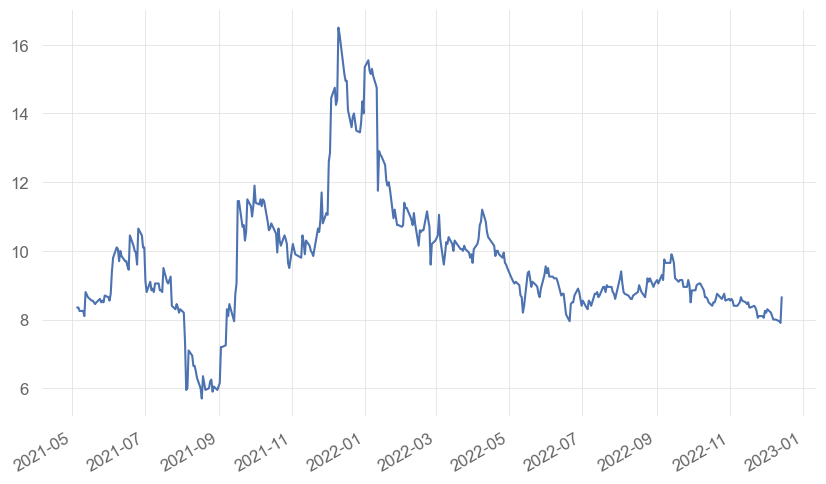

In [234]:
xx['Close'].iloc[-400:].plot()

<Axes: >

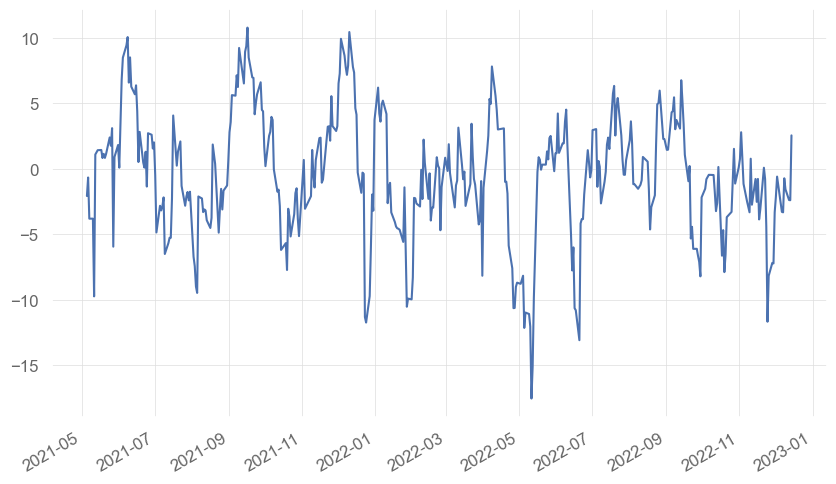

In [235]:
xx['Rolling Sharpe Ratio'].iloc[-400:].plot()

<Axes: >

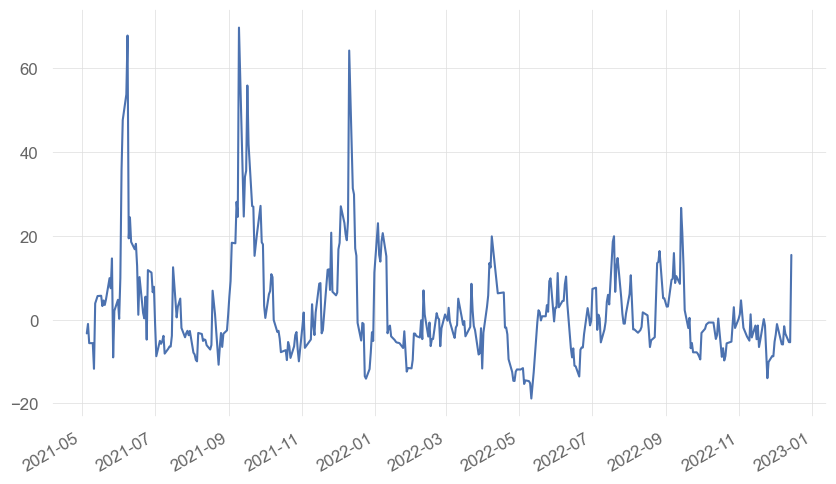

In [236]:
xx['Sortino Ratio'].iloc[-400:].plot()

<Axes: >

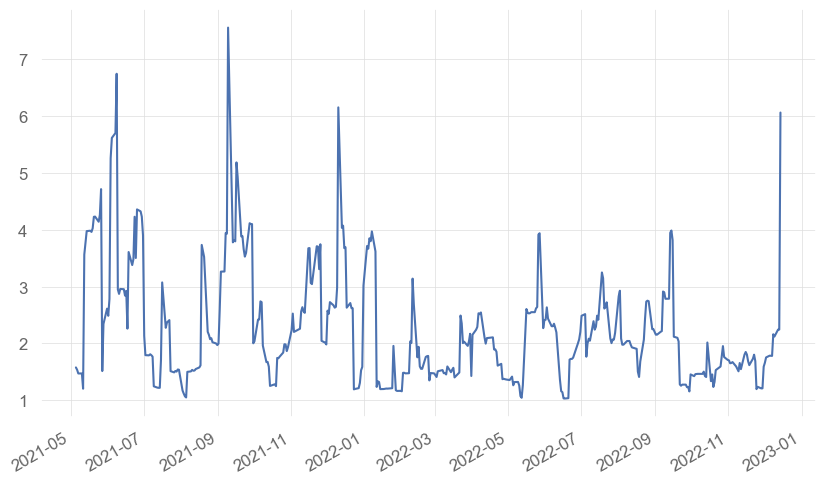

In [237]:
xx['ratio'] = xx['Sortino Ratio']/xx['Rolling Sharpe Ratio']
xx['ratio'].iloc[-400:].plot()

In [142]:

xx = resample_data(df , timeframe='1D')


y = xx['Close'].iloc[-10:].values
x = np.array([i for i in range(len(y))]) 

print( y , "\n x is : " , x)

[48071.5 47862.  47848.5 47216.5 47852.5 47459.  47762.5 48280.5 48484.
 48269. ] 
 x is :  [0 1 2 3 4 5 6 7 8 9]


In [154]:
y = df['Close'].iloc[-50:].values
x = np.array([i for i in range(len(y))])
print(len(x) , len(y))


50 50


In [158]:
from sklearn.linear_model import LinearRegression
x = np.array(range(5)).reshape(-1, 1)  # Needs to be 2D for sklearn
y = xx['Close'].iloc[-5:].values

# Fit the linear regression model
model = LinearRegression()
model.fit(x, y)

# Calculate the slope of the best fit line
slope = model.coef_[0]

# Calculate the angle in radians then convert to degrees
angle_radians = np.arctan(slope)
angle_degrees = np.degrees(angle_radians)

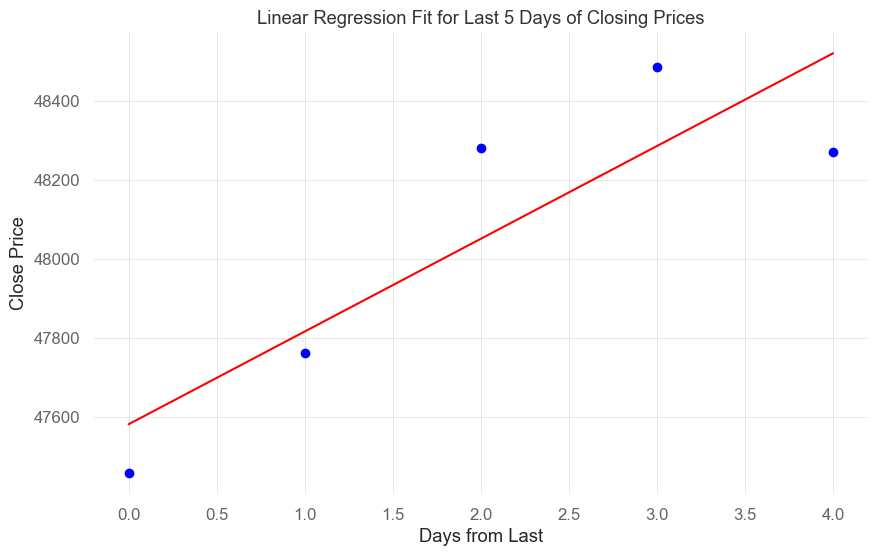

In [162]:
import matplotlib.pyplot as plt

plt.scatter(x, y, color='blue')  # Plot the actual closing prices
plt.plot(x, model.predict(x), color='red')  # Plot the regression line
plt.title('Linear Regression Fit for Last 5 Days of Closing Prices')
plt.xlabel('Days from Last')
plt.ylabel('Close Price')
plt.grid(True)
plt.show()

Slope of the trend line: 0.02925835783406998
Angle of the trend line: 1.675902308931405


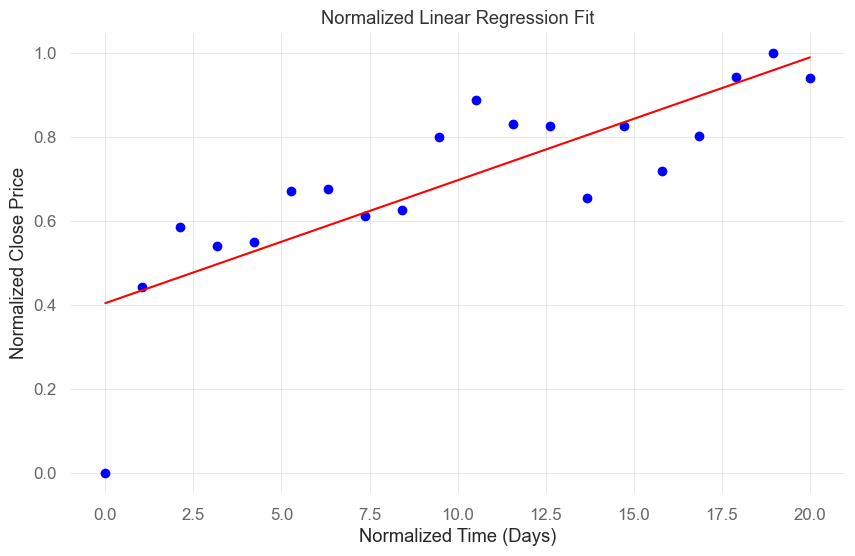

In [175]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import math

# Time in days, evenly spaced across one day
time_days = np.linspace(0, 20, 20)

# Closing prices for each of these times
prices = xx['Close'].iloc[-20:].values

# Normalize prices
prices_min = prices.min()
prices_max = prices.max()
prices_normalized = (prices - prices_min) / (prices_max - prices_min)

# Fit the linear regression model
model = LinearRegression()
model.fit(time_days.reshape(-1, 1), prices_normalized)

# Calculate the slope of the best fit line
slope = model.coef_[0]

# Calculate the angle in radians then convert to degrees
angle_radians = np.arctan(slope)
angle_degrees = np.degrees(angle_radians)

print("Slope of the trend line:", slope)
print("Angle of the trend line:", angle_degrees)

#plt.gca().set_aspect('equal', adjustable='box')
# Plotting for visualization
plt.scatter(time_days, prices_normalized, color='blue')  # Plot the actual normalized closing prices
plt.plot(time_days, model.predict(time_days.reshape(-1, 1)), color='red')  # Plot the regression line
plt.title('Normalized Linear Regression Fit')
plt.xlabel('Normalized Time (Days)')
plt.ylabel('Normalized Close Price')
plt.grid(True)
plt.show()


In [135]:
# Calculate the angle in degrees
angle_radians = np.arctan(model[0])
angle_degrees = np.degrees(angle_radians)

In [ ]:
def rolling_semi_deviation(series, window, target=0):
    """Calculate rolling semi-deviation below the target return."""
    def semi_deviation(sub_series):
        # Filter for returns below the target
        below_target = sub_series[sub_series < target]
        return below_target.std(ddof=0)

    return series.rolling(window=window).apply(semi_deviation, raw=True)



sec_comb_df['Stock_dreturns'] = sec_comb_df['Close'].pct_change()
sec_comb_df['Ssector_d_returns'] = sec_comb_df['Close_index'].pct_change()

# Example: Calculate 10-day rolling semi-deviation for a stock and its sector
sec_comb_df['stock_Rolling_SemiDev'] = rolling_semi_deviation(sec_comb_df['Stock_dreturns'], window=10)
sec_comb_df['Sector_Rolling_SemiDev'] = rolling_semi_deviation(sec_comb_df['Ssector_d_returns'], window=10)

In [ ]:
sec_comb_df['stock_Rolling_SemiDev'].plot()
sec_comb_df['Sector_Rolling_SemiDev'].plot()

In [ ]:
import pytimetk as tk
def find_anomalies(df, column='Close_index' , datetime_col='TIMESTAMP' , iqralpha=0.15):
    
    #iqr_alpha = how senstivie you want thr anomalies to be 0.05-0.5.. lesser the values lesser the anomalies
    import pytimetk as tk
    
    anomalize_df = tk.anomalize(
    data          = df,
    date_column   = datetime_col,
    value_column  = column,
    period        = 5,
    iqr_alpha     = iqralpha, # using the default
    clean_alpha   = 0.75, # using the default
    clean         = "min_max")


    return anomaly_df

    
    
import pytimetk as tk
anomalize_df = tk.anomalize(
    data          = sec_df['NIFTY AUTO'],
    date_column   = sec_df['NIFTY AUTO'].index,
    value_column  = 'Close_index',
    period        = 5,
    iqr_alpha     = 0.15, # using the default
    clean_alpha   = 0.75, # using the default
    clean         = "min_max")    
    
    
find_anomalies(df=sec_df['NIFTY AUTO'], column='Close_index' , datetime_col='TIMESTAMP' , iqralpha=0.2)    
tk.plot_timeseries(xx , date_column="TIMESTAMP" , value_column='Close_index')    



anomalize_df = tk.anomalize(
    data          = xx,
    date_column   = 'TIMESTAMP',
    value_column  = 'Close_index',
    period        = 5,
    iqr_alpha     = 0.15, # using the default
    clean_alpha   = 0.75, # using the default
    clean         = "min_max"
)

anomalize_df.glimpse()

tk.plot_anomalies_decomp(
    data        = anomalize_df,
    date_column = 'TIMESTAMP',
    engine      = 'plotly',
    title       = 'Seasonal Decomposition'
)


tk.plot_anomalies(
    data        = anomalize_df,
    date_column = 'TIMESTAMP',
    engine      = 'plotly',
    title       = 'Plot Anomaly Bands'
)    

In [ ]:

import pandas as pd
import statsmodels.api as sm

# Assuming you have a DataFrame 'df' with a DateTimeIndex and 'Open', 'High', 'Low', 'Close' columns
# df = pd.read_csv('your_ohlc_data.csv', parse_dates=['Date'], index_col='Date')

# Perform the Ljung-Box test on the 'Close' column of the DataFrame
# You need to specify the number of lags for the test. Common practice is to use lags up to 'k' such that k = min(10, len(df)/5)
lags = min(100, len(xx) // 5)
lb_test = sm.stats.acorr_ljungbox(xx['Close_index'], lags=[lags], return_df=True)

print(lb_test)

from statsmodels.tsa.stattools import kpss

# KPSS test
kpss_result = kpss(xx['Log_Return'].dropna(), regression='c')
print(f'KPSS Statistic: {kpss_result[0]}')
print(f'p-value: {kpss_result[1]}')
for key, value in kpss_result[3].items():
    print('Critical Values:')
    print(f'   {key}, {value}')

   
    
def hurst_exponent(time_series):
    """Returns the Hurst Exponent of the time series."""
    lags = range(2, 100)
    tau = [np.sqrt(np.std(np.subtract(time_series[lag:], time_series[:-lag]))) for lag in lags]
    poly = np.polyfit(np.log(lags), np.log(tau), 1)
    return poly[0]*2.0

# Calculate Hurst Exponent
hurst = hurst_exponent(xx['Log_Return'].dropna().values)
print(f'Hurst Exponent: {hurst}')



from statsmodels.tsa.ar_model import AutoReg
import numpy as np

# Fit an AR(1) model
model = AutoReg(xx['Log_Return'].dropna(), lags=1)
model_fit = model.fit()

# Get the coefficient (phi)
phi = model_fit.params[1]

# Calculate the half-life of mean reversion
half_life = -np.log(2) / np.log(phi)
print(f'Half-life of mean reversion: {half_life} periods')import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller

# Assuming you have a DataFrame 'df' with a DateTimeIndex and 'Close' prices
# df = pd.read_csv('your_stock_data.csv', parse_dates=['Date'], index_col='Date')

# Calculate log returns
xx['Log_Return'] = np.log(xx['Close_index']).diff().dropna()

# Check if log returns are stationary
result = adfuller(xx['Log_Return'].dropna())
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')



    
    

In [ ]:
# Function to find all stocks of a sector and do the rebalancing

stock_data_folder = r"C:\Users\Administrator\Downloads\DATA (1)\DATA\NF_200\NF_200_Equity_parquet"

stocks_not_found = []

# Dictionary to hold DataFrame for each index
index_combined_data = {}

cons_names = {}

for index,stock in sec_cons_list.items():
    print("\n Processing index" , index)
        
    # Initialize an empty DataFrame for this index
    index_combined_df = pd.DataFrame()
    
    # Initialize an empty list to store stocks found for this index
    cons_names[index] = []
    
    #--- Process all stocks of one index
    for stk in stock:
        
        print("Finding stock: " , stk)
        
        # Construct the expected file path for the stock's data file
        expected_file_path = os.path.join(stock_data_folder, f"{stk}.csv.parquet")
        
        # Check if the file exists
        if os.path.exists(expected_file_path):
            
            print(f"File for {stk} found.")
            
            df = pd.read_parquet(expected_file_path)
            
            #-- calculate columns for whicb u want to rank on
            
            #df['hr_close'] = x_min_close(df=df , column='Close' , start = '9:15',end='9:45')
            df['todayo'] = df.resample('D')['Close'].first().dropna().reindex(df.index.date).values
            df['prevdayh'] = df['Close'].groupby(df.index.date).max().shift().reindex(df.index.date).values
            df['prevdayc'] = df['Close'].groupby(df.index.date).last().shift().reindex(df.index.date).values
            df['prevdayl'] = df['Close'].groupby(df.index.date).min().shift().reindex(df.index.date).values
            df['10dma'] = daily_moving_average(df=df, timeframe='D' , column='Close', periods=10, agg_func='last')
            df['Trough'] = find_trough_multi_tf(df , column='Close' , highcol='High' , lowcol='Low' , closecol='Close' , opencol='Open' , volcol='Volume' , threshold=3 , distance=5 , timeframe='1D')
            df['Peak'] = find_peak_multi_tf(df , column='Close' , highcol='High', lowcol='Low' , closecol='Close' , opencol='Open' , volcol='Volume' , threshold=3 , distance=5 , timeframe='1D')
            
            
            df['dRSI'] = rsi_timeframe(df ,column='Close' , period=7 , timeframe='1D' )
            df['dATR'] = ATR_multi_timeframe(df=df , timeframe='1D' , length=3 ,  highcol='High' , lowcol='Low' , closecol='Close' , volcol='Volume')
            df['pDATR'] = df['dATR']/df['Close']
            df['Trough_ratio'] = df['prevdayc']/df['prevdayl']
            
            
            # Use numpy.maximum for element-wise comparison and maximum
            
            #df['Ratio'] = df['hr_close'] / ((df['10dma'] + df['prevdayl']) / 2)
            
            
            # Using dictionary comprehension to create a new column names mapping
            columns_mapping = {old_name: f'{stk}_{old_name}' for old_name in df.columns}
                       
            
            df_renamed = df.rename(columns=columns_mapping)
            #print(df_renamed)
            
            if index_combined_df.empty:
                    index_combined_df = df_renamed
            else:
                index_combined_df = index_combined_df.join(df_renamed, how='outer')
            
            
            # Add stock to the list of stocks found for this index
            cons_names[index].append(stk)
            
            
            
        else:
            print(f"File for {stk} not found.")
            stocks_not_found.append(stk)
            
    
    
    #== once all stocks are processed we rank the ratio column for all rows
    all_ratios = index_combined_df.filter(regex='_pDATR')
    all_ratios.rank(ascending=False ,axis=1)
    
    sec_ratios = index_combined_df.filter(regex='_Trough_ratio')
    sec_ratios.rank(ascending=False ,axis=1)

    index_combined_df[[f"{col}_Rank" for col in all_ratios.columns]] = all_ratios.rank(ascending=False, axis=1)
    index_combined_df[[f"{col}_Rank2" for col in sec_ratios.columns]] = sec_ratios.rank(ascending=False, axis=1)
    
    
    
    # Add the combined DataFrame to the dictionary
    index_combined_data[index] = index_combined_df
    
    
    
       
        
#==== index_combined_data contains a dictionary of dataframes for each index and  
# index_combined_df is the iterator
    
    
    



In [33]:
xx = ATR_multi_timeframe(sec_df['NIFTY BANK'] , timeframe='1D' , length=5 , opencol='Open', highcol='High' , lowcol='Low' , closecol='Close' , percent=False)

In [101]:

def improved_ATR(df , period=3 , column_for_ATR = 'Close' , timeframe='1D' , high_col='High' , low_col = 'Low' , open_col = 'Open' , close_col = 'Close' , volcol='Volume'   ):
    
    
    """
    Calculate the Improved ATR (Average True Range) based on typical price and exponential moving average (EMA).
    
    Args:
        df (DataFrame): The DataFrame containing market data.
        period (int): The period over which EMA and ATR are calculated.
        column_for_ATR (str): Not used in this function version, can be ignored.
        timeframe (str): The resampling timeframe for the data (e.g., '1D' for daily).
        high_col (str): Column name for high prices.
        low_col (str): Column name for low prices.
        open_col (str): Column name for open prices.
        close_col (str): Column name for close prices.
        volcol (str): Column name for volume data.

    Returns:
        Series: A series containing the Improved ATR values.
    """
    
    
    from copy import deepcopy
    df_copy = deepcopy(df)    
    
    daily_data = resample_data(df , highcol = high_col , lowcol = low_col , closecol = close_col , opencol = open_col  , volcol = volcol , timeframe = timeframe)
    
       
    daily_data["typ_price"] = (daily_data['High'] + daily_data['Low'] + daily_data['Close'])/3
    
    
    daily_data['mac'] = daily_data["typ_price"].ewm(span=period, adjust=False).mean()
    
    daily_data = daily_data.shift(1)
    #print(daily_data)
    
    atrv = pta.atr(daily_data['High'], daily_data['Low'], daily_data['Close'], length=period  , talib=talib  , percent=False)
   
    #print(atrv)
    
    # Calculate the Improved ATR formula
    atrex = (((daily_data["Close"] - daily_data['mac']) /daily_data["Close"]) * 100) * ((atrv / daily_data["Close"]) * 100)
    
    #atrex = atrex.shift(1)
    
    atrex = atrex.reindex(df.index, method='ffill')
    
    
    
    return atrex
    
    

In [102]:
xx = improved_ATR(sec_df['NIFTY BANK'] , timeframe='1D' , period=5 , open_col='Open', high_col='High' , low_col='Low' , close_col='Close' )

In [ ]:
index_to_consider = 'NIFTY 50'

stocks_to_do = cons_names[index_to_consider]


In [ ]:
#"C:\Users\Administrator\Downloads\DATA (1)\DATA\index\NIFTY50\NIFTY50.csv"

index_data_loc = r"C:\Users\Administrator\Downloads\DATA (1)\DATA\index\NIFTY50\NIFTY50.csv"

bank_index = r"C:\Users\Administrator\Downloads\DATA (1)\DATA\index\BANKNIFTY\BANKNIFTY.csv"

def process_index(indexpath , timeframe='30Min'):
        

    index_df = pd.read_csv(indexpath)
    
    if 'datetime' in index_df.columns:
    
        index_df.datetime = pd.to_datetime(index_df.datetime , format="%d-%m-%Y %H:%M")
        index_df.set_index('datetime' , inplace=True)
    #print(index_df.columns)
    columns_to_check = ['open', 'high', 'low', 'close' , "volume"]
    rename_mapping = {
        'open': 'Open',
        'high': 'High',
        'low': 'Low',
        'close': 'Close',
        'volume': 'Volume'
        # Add other column mappings if necessary
    }

    # Check if all specified columns exist in the DataFrame
    if all(column in index_df.columns for column in columns_to_check):
        index_df = index_df.rename(columns=rename_mapping)  

  
    
    index_df = index_df[(index_df.index.dayofweek<5)]

    ind_df = resample_data(index_df , highcol = 'High' , lowcol = 'Low' , closecol = 'Close' ,opencol = 'Open'  , volcol = 'Volume' , timeframe = timeframe)

    #print(ind_df) 
    
    ind_df['ind20DMA'] = daily_moving_average(df=ind_df, timeframe='D' , column='High', periods=10, agg_func='last')
        
    ind_df['indtodayo'] = ind_df.Open.groupby(ind_df.index.date).first().reindex(ind_df.index.date).values
    ind_df['indprevdayc'] = ind_df.Close.groupby(ind_df.index.date).last().shift().reindex(ind_df.index.date).values
    ind_df['indprevdayl'] = ind_df.Low.groupby(ind_df.index.date).min().shift().reindex(ind_df.index.date).values
    ind_df['indprevdayh'] = ind_df.High.groupby(ind_df.index.date).max().shift().reindex(ind_df.index.date).values
    ind_df['indprevdayo'] = ind_df.Open.groupby(ind_df.index.date).first().shift().reindex(ind_df.index.date).values
    ind_df['nif_fhigh'] = x_min_high(df=ind_df , column='High' , start = '9:15',end='10:05') 
    ind_df['nif_flow'] =  x_min_low(df=ind_df , column='Low' , start = '9:15',end='10:05')
    
    
    ind_df['near_Exp'] = get_prev_exp(ind_df.index , symbol='NIFTY')
    
    ind_df['ind_todayh'] = intraday_high(df=ind_df ,high_col= 'High' ,agg_func= 'max')
    ind_df['ind_todayl'] = intraday_low(df=ind_df ,low_col= 'Low' , agg_func='min')
            
    ind_df['indexpiry_high'] = expanding_high_since_expiry(ind_df , expiry_series='near_Exp' , column='High')
        
    ind_df['indexpiry_low'] = expanding_low_since_expiry(ind_df , expiry_series='near_Exp' , column='Low')
    ind_df['ind_zc_ROC'] = daily_ROC(ind_df , column='Close' , ROC_period=5 , z_score_period=40)                          
    
        
    ind_df = ind_df[(ind_df.index.year>=2021) & (ind_df.index.year<2024)]
    
    
    #ind_df = ind_df.reindex(combined_df.index, method='ffill')
            
    return ind_df
    


In [ ]:
ind_df = process_index(index_data_loc , timeframe='30Min')
ind_df = ind_df.rename(columns={
    'Open': 'indOpen',
    'High': 'indHigh',
    'Low': 'indLow',
    'Close': 'indClose',
    # Add other column mappings if necessary
})

print(ind_df)

In [ ]:

def process_symbol(df , index=ind_df, stk=stk):
    
    
    df = df.sort_index()
    
    #-- Change back the symbols
    
    #df['first_hr_high'] =  x_min_high(df , 'High' , start='09:30' , end='11:00' )
   # df['cval'] = x_min_cum_vol(df , 'Volume' , start='09:30' , end=rank_time)
    df['x_day_low'] = get_x_day_low(df, n=10 , column=f'{stk}_Close')
    #df['x_day_high'] = get_x_day_high(df , n=10 , column=f'{stk}_Close')
   
    #f'{stk}_f'{stk}_Close''
    
    #df['5drng'] = get_x_day_range(df , n=5, high_col=f'{stk}_Close' , low_col=f'{stk}_Close')
    
    #df['20DMA'] = daily_moving_average(df , 'D' , f'{stk}_Close' , periods=5 , agg_func='last')
    
    #df[fname+'_ratio'] = df['cval']/df['D_Volume_moving_average']
        
    #df['todayo'] = df.resample('D')[f'{stk}_Close'].first().dropna().reindex(df.index.date).values
    df['prevdayc'] = df[f'{stk}_Close'].groupby(df.index.date).last().shift().reindex(df.index.date).values
    df['secdayc'] = df[f'{stk}_Close'].groupby(df.index.date).last().shift().reindex(df.index.date).values
    
    #df['ratio_co'] = df['f'{stk}_Close'']/(df[['todayo', 'prevdayc']].max(axis=1))
    #df['prevdayl'] = df[f'{stk}_Close'].groupby(df.index.date).min().shift().reindex(df.index.date).values
    #df['prevdayh'] = df[f'{stk}_Close'].groupby(df.index.date).max().shift().reindex(df.index.date).values
    df['prevdayo'] = df[f'{stk}_Close'].groupby(df.index.date).first().shift().reindex(df.index.date).values
    df['EOD'] = df.index.to_series().dt.date != df.index.to_series().shift(-1).dt.date
    #df['slope'] = find_slope_and_prediction(df , 'Low' , window=100)[0]
    #df['vwap'] = intraday_vwap(df)
    
#     df['ATR'] = ATR(highcol=df['High'] , lowcol=df['Low'] , f'{stk}_Close'col=df['f'{stk}_Close''] , length=7 , percent=False , mamode='WMA')
#     df['ATR_zc'] = z_score_price(df ,  'ATR' , window_size=3)
#     df['z_score'] = z_score_price(df , column='High' , window_size=13)
    
    
    #=== Find ATR and z-score of ATR
#     df['ATR'] = ATR(highcol=df['High'] , lowcol=df['Low'] , f'{stk}_Close'col=df['f'{stk}_Close''] , length=14 , percent=False , mamode='WMA')
#     df['ATR_zc'] = z_score_price(df ,  'ATR' , window_size=50)
    
    #df['last_trough'] = find_trough_multi_tf(df , column='Low' , threshold=0.25, distance=5 , timeframe='1D')
        
    #df , close_col = 'Close' , low_col = 'Low' , high_col='High')
    df = pivot_points_classic(df=df , close_col=f'{stk}_Close' , low_col = f'{stk}_Low' , high_col=f'{stk}_High')
    
    df['todayl'] = intraday_low(df=df , low_col=f'{stk}_Close' , agg_func='min')
    df['todayh'] = intraday_high(df=df , high_col=f'{stk}_Close' , agg_func='max')
    #df['daily_RSI'] = rsi_timeframe(df ,period=7 , timeframe='1D' )
    #df['zc_ROC'] = daily_ROC(df , column='f'{stk}_Close'' , ROC_period=3 , z_score_period=40)
    df = df[(df.index.year>=2021) & (df.index.year<2024)]
            
    #====== Index based conditions in any
    
    index = index.reindex(df.index, method='ffill')
    
    df = pd.concat( [df, ind_df], axis=1)
    
    #print(  "\n Concated df with index is : " , df)
   
    
    #df['int_indHigh'] = intraday_high(df=df , high_col='indHigh' , agg_func=)
    
    #=== Long conditions
    # df['ratio_co']>1.005 
    
    condition1 = df.index.time>=datetime.time(10 , 15) 
    condition2 = df[f'{stk}_pDATR_Rank']<=40    
    condition3 = df[f'{stk}_Trough_ratio_Rank2']<=30
    condition5 = df[f'{stk}_dRSI']<70
    
    condition6 = df['indtodayo']>df["indprevdayc"]*0.997
    condition10 = df['indClose']<df['indtodayo']*1.02
    condition11 = df['indprevdayc']<df['indprevdayo']*1.02
    condition7 = df['indLow']>df["indprevdayl"]*1.001
    condition8 = df['ind_zc_ROC']<=3
#    condition9 = df[f'{stk}_Close']
    
    df[f'{stk}_signal'] = condition1 & condition2 & condition5 & condition6 & condition10 & condition7 & condition11 
        
    #=== For short signals
    
#     condition11 = df.index.time==datetime.time(9 , 45)
#     condition12 = df[f'{stk}_dRSI_Rank']>47
#     condition6 = df[f'{stk}_Ratio']<0.995
    
    
#     df[f'{stk}_short_signal'] = condition11 & condition12 & condition6 
    
    
    ofol = df_folder
    ofil = os.path.join(ofol , f'{stk}.csv')
    #print(ofil)
    df.to_csv(ofil)
    
           

    # Compute the final result and return it as a pandas DataFrame
    return df 
    


In [ ]:
def process_signal(df, side=1 , intra_Exit=0 , n_day_Exit=2, symbol=None ):
    
    #================================================================================================
    if symbol is None:
        raise ValueError("Symbol must be provided")
    
    print("\n Processing signals of", stk )
    
    log = []
    bar_counts = [0] * len(df)
    positions = [0]* len(df)
    position = 0
    day_count = 0
    entry_price = 0 
    exit_price = 0 
    ordern = 0 
    orders = [0]*len(df)
    highest_high = 0 
    # Compute date changes using diff()
    #df['date_changed'] = df.index.to_series().diff().dt.days != 0
    
        # Ensure your index is a DateTimeIndex and sorted.
    df['date_changed'] = df.index.to_series().dt.date != df.index.to_series().shift(1).dt.date
    
    #================================================================================================
            
    for i in range(len(df)):
        
        row = df.iloc[i]
        current_date = df.index[i].date()
                
        # If in a position, increment the bar count
        if position != 0:
                        
            #df.loc[i, 'bar_count'] = df.loc[i - 1, 'bar_count'] + 1  # increment bar_count in df
            bar_counts[i] = bar_counts[i-1] + 1
            if row['date_changed']:
                #print("the date changed")
                day_count += 1
                                           
            else:
                day_count = day_count
        else:
            #bar_count = 0
            #df.loc[i, 'bar_count'] = 0 
            bar_counts[i] =0 
            ordern = 0 
            day_count = 0
            entry_price = 0
        
        # ---- HIghest high and lowest low after in position....
        
        highest_high = row[f'{stk}_Close'] if position != 0 and row[f'{stk}_Close'] > highest_high else highest_high if position > 0 else 0
        lowest_along = row[f'{stk}_Close'] if position != 0 and row[f'{stk}_Close'] < lowest_along else lowest_along if position > 0 else 0
        
        # and df[f'{stk}_Close'][i]<df['R2'][i-1] not helping
        
        if df[f'{stk}_signal'][i]==1 and df['indHigh'][i]>df['nif_fhigh'][i-1]*0.999 and df[f'{stk}_Close'][i]<df[f'{stk}_High'][i-1] and position == 0 and df[f'{stk}_Close'][i]>df[f'{stk}_prevdayl'][i-1]*1.001 and df[f'{stk}_Close'][i]>df['S1'][i-1] :
            # Determine if it's a long or short entry
            if side > 0:
                position = 1
                entry_price = row[f'{stk}_Close']
                ordern = 1                 
                print("\n Position taken long at : " , df.index[i] , "- entry- :  " , entry_price , "rank: " , df[f'{stk}_pDATR_Rank'][i] )
                #print("\n " , "Position details:  prevdayl : " , df[f'{stk}_prevdayl'][i] , "10dma " , df[f'{stk}_10dma'][i])
                log.append((df.index[i], symbol, position , entry_price , ordern))
                #print("\n" , df['5drng'][i])
        
        
#         if df[f'{stk}_short_signal'][i]==1 and position == 0 :
        
#             if side == 2:
                
#                 position = -1
#                 entry_price = row[f'{stk}_Close']
#                 ordern = -1 
#                 print("\n Position taken Short at : " , df.index[i] , "-- entry Price - :  " , entry_price , ": position: " , position)
#                 log.append((df.index[i], symbol, position , entry_price, ordern))
        
        # ------- short Stop loss
        
        if position ==-1 and row[f'{stk}_Close'] > max(df[f'{stk}_todayo'][i]*1.005 ,entry_price*1.015)  and bar_counts[i]>=1:
            
            print("\n Short Position Hit stop " , df.index[i] , "at: ", row[f'{stk}_Close'], " - Today open: " ,df[f'{stk}_todayo'][i]  )
            
            position = 0
            bar_counts[i] = 0
            exit_price = row[f'{stk}_Close']
            ordern = -13
            log.append((df.index[i], symbol, position , exit_price, ordern))
        
        # ==== Long stop loss
        
        if position == 1 and row[f'{stk}_Close'] < min(df[f'{stk}_todayo'][i]*1.001 ,entry_price*0.98)  and bar_counts[i]>1:
            
            #print("\n Position Hit stop " , df.index[i] , "at: ", row[f'{stk}_Close'], " - Today open: " ,df[f'{stk}_todayo'][i]  )
            
            position = 0
            bar_counts[i] = 0
            exit_price = row[f'{stk}_Close']
            ordern = 13
            log.append((df.index[i], symbol, position , exit_price, ordern))
        
        if position == 1 and row[f'{stk}_Close'] <min(df[f'{stk}_Open'][i]*0.995 ,df[f'{stk}_prevdayl'][i])  and bar_counts[i]>1:
            
            print("\n Big loss " , df.index[i] , "at: ", row[f'{stk}_Close'], " - prev day low: " ,df[f'{stk}_prevdayl'][i]  )
            
            position = 0
            bar_counts[i] = 0
            exit_price = row[f'{stk}_Close']
            ordern = 13
            log.append((df.index[i], symbol, position , exit_price, ordern))
        
            
#         if position == 1 and df['indClose'][i]< min(df['indprevdayc'][i]*0.98 ,df["nif_flow"][i]*0.99)  and bar_counts[i]>12:
            
#             print("\n Index Hit stop " , df.index[i] , "at: index close ", df['indClose'][i], " - prevdayc: " ,df['indprevdayc'][i]  )
#             position = 0
#             bar_counts[i] = 0
#             exit_price = row[f'{stk}_Close']
#             ordern = 13
#             log.append((df.index[i], symbol, position , exit_price, ordern))


        
        # ---- End of Day Exit condition based on parameter intra_exit
        
        # ---- print("position " ,position , df['bar_count'][i])
        
        if position != 0 and intra_Exit==1 and df.index[i].time()>= datetime.time(15, 1) and bar_counts[i] > 1:
            
            #print("Hi")
            print("\n Position exit EOD  at" , df.index[i] , position , "position at  ", row[f'{stk}_Close'] )
            
            position = 0
            bar_counts[i] = 0
            exit_price = row[f'{stk}_Close']
            ordern = 11 
            log.append((df.index[i], symbol, position , exit_price))
        
        
        if position != 0 and intra_Exit==1 and df['EOD'][i]==1 and bar_counts[i]>1:
            
            #print("Hi")
            #print("\n Position exit EOD via code" , df.index[i] , position , "position at  ", row[f'{stk}_Close'] )
            
            position = 0
            bar_counts[i] = 0
            exit_price = row[f'{stk}_Close']
            ordern = 11 
            log.append((df.index[i], symbol, position , exit_price))
        
        
        
#         if position != 0 and bar_counts[i]>4 and df['indClose'][i]<df["indOpen"][i-1]*0.985 and df['High'][i]<df['todayh'][i-1]*0.985:
            
#             #print("Hi")
#             #print("\n Nifty bear exit at: " , df.index[i] ,"Nifty high and highest are:  "  ,df['indHigh'][i] , df['ind_todayh'][i-1]  )
            
#             position = 0
#             bar_counts[i] = 0
#             exit_price = row[f'{stk}_Close']
#             ordern = 11 
#             log.append((df.index[i], symbol, position , row[f'{stk}_Close']))
        
               
                
        if position > 0 and day_count>=1 and df.index[i].time()>= datetime.time(9, 45) and bar_counts[i]>6 and df[f'{stk}_todayo'][i]<df[f'{stk}_prevdayl'][i]*0.99 and df[f'{stk}_Close'][i]<df[f'{stk}_Close'][i-1]  :
            print("\n prev day exit down exit EOD long at" , df.index[i] , position , "position at  ", row[f'{stk}_Close'] , "Day_count: " , day_count  )
        
            position = 0
            bar_counts[i] = 0
            exit_price = row[f'{stk}_Close']
            ordern = 13
            log.append((df.index[i], symbol, position , row[f'{stk}_Close'], ordern))
        
#         if position > 0 and day_count>=1 and bar_counts[i]>3 and df[f'{stk}_Close'][i]<df['Open'][i]*0.985  :
#             #print("\n Large bear bar" , df.index[i]  , "Day_count: " , day_count , "close: " , df[f'{stk}_Close'][i] , df['Open'][i] )
        
#             position = 0
#             bar_counts[i] = 0
#             exit_price = row[f'{stk}_Close']
#             ordern = 13
#             log.append((df.index[i], symbol, position , row[f'{stk}_Close'], ordern))
                
        
        if position != 0 and intra_Exit==0 and day_count>=n_day_Exit and bar_counts[i]>1 and df[f'{stk}_Close'][i]<df[f'{stk}_Close'][i-1]  :
            
            #print("\n Carryforward exit EOD long at" , df.index[i] , position , "position at  ", row[f'{stk}_Close'] , "Day_count: " , day_count )
            
            position = 0
            bar_counts[i] = 0
            exit_price = row[f'{stk}_Close']
            ordern = 12
            log.append((df.index[i], symbol, position , row[f'{stk}_Close'], ordern))
                
        
        #---- Stop-loss of 3%
        
        if position!=0 and df[f'{stk}_todayo'][i]<df['x_day_low'][i] and df[f'{stk}_Close'][i]<df[f'{stk}_Low'][i-1] and day_count>=1 and df.index[i].time()>=datetime.time(10 , 00):
            
            position = 0
            bar_counts[i] = 0
            exit_price = row[f'{stk}_Close']
            ordern = 12
            log.append((df.index[i], symbol, position , row[f'{stk}_Close'], ordern))
            
            #print("\nBreakdown opening exit from low:  " , df['x_day_low'][i] ,   " -- open at" , df['todayo'][i])
        
#         if position!=0 and df['High'][i]<df['S1'][i-1] and df[f'{stk}_Close'][i]<df[f'{stk}_Close'][i-1] and day_count>=1 and df.index[i].time()>=datetime.time(10 , 00):
            
#             position = 0
#             bar_counts[i] = 0
#             exit_price = row[f'{stk}_Close']
#             ordern = 13
#             log.append((df.index[i], symbol, position , row[f'{stk}_Close'], ordern))
    
        
        
        #=== exit of open==high of the day
        
#         if position>0 and day_count>=3  and df[f'{stk}_Close'][i]>=df['prevdayh'][i]*1.01 and df.index[i].time()>=datetime.time(10 , 00):
            
#             position = 0
#             bar_counts[i] = 0
#             exit_price = row[f'{stk}_Close']
#             ordern = 12
#             log.append((df.index[i], symbol, position , row[f'{stk}_Close'], ordern))
            
#             #print("\n reversal from low:  " ,df['prevdayh'][i],   " -- open at" , df['todayo'][i] , "reversal at: " , df['prevdayc'][i] )
                
        
        positions[i] = position
        orders[i] = ordern
    
    
#         #----- 5drnag exit
        
#         if position == 1 and row[f'{stk}_Close'] > entry_price*(1+(1.25*df['5drng'][i])) and df[f'{stk}_Close'][i]>df[f'{stk}_Close'][i-1] and bar_counts[i]>10:
            
#             #print("\n Range target  " , df.index[i] , "at  ", row[f'{stk}_Close'] , " range: " , df['5drng'][i] , "entryprice" , entry_price )
#             position = 0
#             bar_counts[i] = 0
#             ordern = 15
#             log.append((df.index[i], symbol, position , row[f'{stk}_Close'], ordern))
        
#          #----- reistance exit
        
        if position >0 and df[f'{stk}_Close'][i-1]>df['R2'][i-1]*1.02 and df[f'{stk}_Close'][i]<df['R2'][i-1]*1.02 and bar_counts[i]>5 and df.index[i].time() >= datetime.time(9, 30):
            
            print("\n Resistance target  " , df.index[i] , "at  ", row[f'{stk}_Close'] , " R2 prev: " , df['R2'][i-1]  )
            position = 0
            bar_counts[i] = 0
            ordern = 16
            log.append((df.index[i], symbol, position , row[f'{stk}_Close'], ordern))
    
    
    #print("\n Position at last bar is " , positions[-1]   )
    
    df[symbol+'bar_count'] = bar_counts
    df[symbol+'_order'] = orders
    df[symbol+'_position'] = positions
    
    #== these are bar-by-bar returns when you are in position 
    df[symbol+'_ret'] = np.where(df[symbol+'bar_count']>0 ,  df[f'{stk}_Close'].pct_change()*side , 0)
        
    #=== 
    df[symbol+'_Close'] = df[f'{stk}_Close']

    trade_log = create_tradelog(df , Symbol=symbol)


#     if( num_entries!=num_exits):

#         print("\n \n Number of entries and exits dont match"  , "Entries: " , num_entries , "----- Exits" , num_exits  )
#trades_strategy_folder 
    # Construct the file path
    file_path = os.path.join(trades_strategy_folder, f"{symbol}.csv")
    trade_log.to_csv(file_path )

        
    
    return df[[symbol+'_Close' , symbol+'_position' ,symbol+'_ret' , symbol+'bar_count', symbol+'_order']] 


In [ ]:
combined_df = pd.DataFrame()

count = 0 
for stk in stocks_to_do:
    
    
    print("\nProcessing stock: " , stk)
    
    df = index_combined_data[index_to_consider].filter(regex=stk)
    
    
    #print(df)
 
    
    df = process_symbol(df , index=ind_df , stk=stk)

    #print(df)
    
    df = process_signal(df , side=2 , intra_Exit=0 , n_day_Exit=3, symbol=stk )
    
    count+=1
    
    combined_df = pd.concat([combined_df , df], axis=1, join='outer')

    
print("\n Total stocks processed are: " , count)    
    

In [279]:
#----- function to read trade logs and find total profit from all of symbols for them

def read_trade_log(logloc):
    
    
    
    symbol = os.path.splitext(os.path.basename(logloc))[0].lstrip('_')
    print("\n Processing trade log of symbol" , symbol)
    
    
    df = pd.read_csv(logloc)
    if df.empty:
        print("No trades found")
        return None
    else:
        
        print(df.columns)
        df['Entry Price'] = df['Entry Price'].astype('float')
        df['Exit Price'] = df['Exit Price'].astype('float')
        
        # Drop rows where entry_price or exit_price is NaN
        df.dropna(subset=['Entry Price', 'Exit Price'], inplace=True)
        
        
        if 'Side' in df.columns:
            df['returns'] = np.where(df['Side']=='long' , (df['Exit Price']/df['Entry Price'])-1 , (df['Exit Price']-df['Entry Price'])/df['Entry Price'])
        #print(df)
        
        else:
            
            df['returns'] =  (df['Exit Price']/df['Entry Price'])-1
        
        
        net_return = (100000*df["returns"]).cumsum()
        net_return.dropna(inplace=True)
        print( "Symbol return from trade log is : ", net_return.iloc[-1]) 
        return symbol , net_return.iloc[-1]


    
def concatenate_trades(logloc , comb_df , add_slippages=0 , slippage_in_ticks=1 ,min_movement = 0.05):
    
    
    symbol = os.path.splitext(os.path.basename(logloc))[0].lstrip('_')
    print("\n Concqatenating trades of symbol" , symbol)
    
    
    df = pd.read_csv(logloc)
    if df.empty:
        print("No trades found")
        return None
    else:
        
        # Convert entry_price and exit_price to numeric, set errors='coerce' to handle non-numeric
        df['Entry Price'] = pd.to_numeric(df['Entry Price'], errors='coerce')
        df['Exit Price'] = pd.to_numeric(df['Exit Price'], errors='coerce')
  
        
        
        if add_slippages>0:


            df['Entry Price'] = np.where(df['Side']=='long' , (df['Entry Price'] + (slippage_in_ticks*min_movement))  ,  (df['Entry Price'] - (slippage_in_ticks*min_movement)))

            df['Exit Price'] = np.where(df['Side']=='long' , (df['Exit Price'] - (slippage_in_ticks*min_movement))  ,  (df['Exit Price'] + (slippage_in_ticks*min_movement)))

            #print("\n After adding slippages" , df)

               
        # Drop rows where entry_price or exit_price is NaN
        df.dropna(subset=['Entry Price', 'Exit Price'], inplace=True)
        
        comb_df = pd.concat([comb_df , df] , axis=0 , join='outer')
        
        
        return comb_df
    
    
    
    
cdf = pd.DataFrame()
all_trades = pd.DataFrame()

log_path = trades_strategy_folder


print("\ Reading all trade files from folder " , log_path)

if os.path.exists(log_path):
        file_paths = glob.glob(log_path + "/*.csv")
        
        for file in file_paths:
            
            result = read_trade_log(file)
            if result is not None:
                sym, profit = result
            
            cdf = cdf.append({'Symbol': sym, 'Profit': profit}, ignore_index=True)
            all_trades = concatenate_trades(file , all_trades , add_slippages=0 ,slippage_in_ticks=3 )
        
        all_trades.to_csv(output_all_trades_file)

 
        

#-- this is the win ratio
print(len(all_trades[all_trades['Exit Price']>all_trades['Entry Price']])/len(all_trades))

from Process_trade_log_equity import*
#== Code to read all the trades from the strategy folder and than find the trade stats

if os.path.exists(output_all_trades_file):
    print("Output htlml trade file exists as: " ,output_all_trades_file)
    
    create_trade_report(output_all_trades_file , starting_capital=10000000 , output_html_path=trade_html_file)        
        

\ Reading all trade files from folder  C:\Users\Administrator\Documents\symbol_wise_trades\Sector_ranking_long_intraday_2

 Processing trade log of symbol Nifty Auto
Index(['Unnamed: 0', 'Symbol', 'Side', 'Trade ID', 'Start Time', 'End Time',
       'Entry Price', 'Exit Price'],
      dtype='object')
Symbol return from trade log is :  54098.3287576289

 Concqatenating trades of symbol Nifty Auto

 Processing trade log of symbol NIFTY BANK
Index(['Unnamed: 0', 'Symbol', 'Side', 'Trade ID', 'Start Time', 'End Time',
       'Entry Price', 'Exit Price'],
      dtype='object')
Symbol return from trade log is :  16480.71950601373

 Concqatenating trades of symbol NIFTY BANK

 Processing trade log of symbol Nifty Commodities
Index(['Unnamed: 0', 'Symbol', 'Side', 'Trade ID', 'Start Time', 'End Time',
       'Entry Price', 'Exit Price'],
      dtype='object')
Symbol return from trade log is :  15512.035123927115

 Concqatenating trades of symbol Nifty Commodities

 Processing trade log of symb

c:\Users\Administrator\Desktop\Repos\Equity_Backtester_v1\Process_trade_log_equity.py:695: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  modified_groups = df_copy.resample('M').apply(add_value)


{'Total Trades': 1398, 'Average Profit Perc per trade ': '0.30%', 'Average Profit(Absolute) per trade ': 307.08, 'Win Percentage ': '52.00%', 'Loss Percentage ': '48.00%', 'Expectancy Ratio ': '1.48', 'Avg Holding period (min)': '773.62', 'Avg Monthly Return ': '0.09', 'Avg Monthly Return on Exposure ': '0.09', 'Avg Monthly Drawdown on Exposure ': '-0.10%', 'Avg Trades per Day ': '2.04', '% days traded in a year(days) ': '271.00%'}

 Found trades:  ['long']


c:\Users\Administrator\Desktop\Repos\Equity_Backtester_v1\Process_trade_log_equity.py:695: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  modified_groups = df_copy.resample('M').apply(add_value)
c:\ProgramData\Anaconda3\lib\site-packages\quantstats\stats.py:968: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  returns = returns.pivot('Year', 'Month', 'Returns').fillna(0)


In [ ]:

#-- this is the win ratio
print(len(all_trades[all_trades['exit_price']>all_trades['entry_price']])/len(all_trades))

#== Code to read all the trades from the strategy folder and than find the trade stats

if os.path.exists(output_all_trades_file):
    print("Output htlml trade file exists as: " ,output_all_trades_file )
    create_trade_report(output_all_trades_file , starting_capital=10000000 , output_html_path=trade_html_file)

In [ ]:
Total Trades': 2076, 'Average Profit Perc per trade ': '0.20%', 'Average Profit(Absolute) per trade ': 219.54, 'Win Percentage ': '54.00%', 'Loss Percentage ': '46.00%', 'Expectancy Ratio ': '1.44', 'Avg Holding period (min)': '527.00', 'Avg Monthly Return ': '0.10', 'Avg Monthly Return on Exposure ': '0.09', 'Avg Monthly Drawdown on Exposure ': '-0.11%', 'Avg Trades per Day ': '2.49', '% days traded in a year(days) ': '331.00%'}

In [253]:
def plot_signal2_equity_from_file( tradelog_file ,unddf_file, signal_date , stk):
        
        
        """
            plot_signal- Iterates over the tradelist and plot the signal u want
            
            Parameters
            ----------
            
            signal_date: string or datetime
                the date for which you want to see the signals
                   
        
        """
         
            
        import mplfinance as mpf 
        import matplotlib.pyplot as plt
        import matplotlib.gridspec as gridspec
        from datetime import timedelta
         
        
        tradelog = pd.read_csv(tradelog_file)
        
        tradelog['entry_time'] = pd.to_datetime(tradelog['entry_time'])
        tradelog['exit_time'] = pd.to_datetime(tradelog['exit_time'])
        
        print("\n Found trade log as : " , tradelog)
        und_df = pd.read_csv(unddf_file)
        
        und_df = und_df[["Unnamed: 0",f'{stk}_High',f'{stk}_Low',f'{stk}_Close',f'{stk}_Open']]
        
        
        if 'Unnamed: 0' in und_df.columns:

            und_df['Unnamed: 0'] = pd.to_datetime(und_df['Unnamed: 0'] , format ="%Y-%m-%d %H:%M:%S")
            und_df.rename(columns={'Unnamed: 0':'DateTime'} , inplace=True)


        und_df.set_index('DateTime' , inplace=True)    
        
        
             # Renaming columns for mplfinance
        plot_columns = {
            f'{stk}_Open': 'Open',
            f'{stk}_High': 'High',
            f'{stk}_Low': 'Low',
            f'{stk}_Close': 'Close'
        }
        und_df.rename(columns=plot_columns, inplace=True)

        
        
        if isinstance(signal_date, str):
            signal_date = datetime.datetime.strptime(signal_date, '%Y-%m-%d %H:%M:%S')
        
        df_date =tradelog[tradelog['entry_time'].dt.date == signal_date]
        df_date.reset_index(inplace=True)
        
        print("Found trade as : " , df_date)
        
        fig = plt.figure(figsize=(12, 8))

        # create GridSpec with 2 rows and 2 columns
        gs = gridspec.GridSpec(2, 2, figure=fig)
        # Create my own `marketcolors` style:
        mc = mpf.make_marketcolors(up='b', down='r')
        s = mpf.make_mpf_style(base_mpl_style='bmh', marketcolors=mc)
        
        for i, trade in df_date.iterrows():
            # Fetch historical data
            entry_time = trade['entry_time']
            exit_time = trade['exit_time']

            string_leg = trade['Side']
            
            und_req = und_df[(und_df.index.date>=entry_time.date()-timedelta(days=3)) & (und_df.index.date<=exit_time.date()+timedelta(days=2)) ]
           
            #print(option_df_temp)
            t = fig.add_subplot(gs[0, i])
            t.grid(True, color='darkgrey')
            mpf.plot(und_req,style=s,type='candle',vlines=dict(vlines=[f'{str(entry_time)}',f'{str(exit_time)}'],linewidths=(1,1)),ax=t,axtitle="Trade")
            plt.tight_layout()
            plt.show()
        #For underlyiung
#         unddf = unddf[unddf.index.date == signal_date]
#         t = fig.add_subplot(gs[1, :])
#         t.grid(True, color='darkgrey')
#         mpf.plot(unddf,style=s,type='candle',ax=t,axtitle=f"Underlying")
        


In [ ]:
def plot_req_OHLC

<Axes: xlabel='Date'>

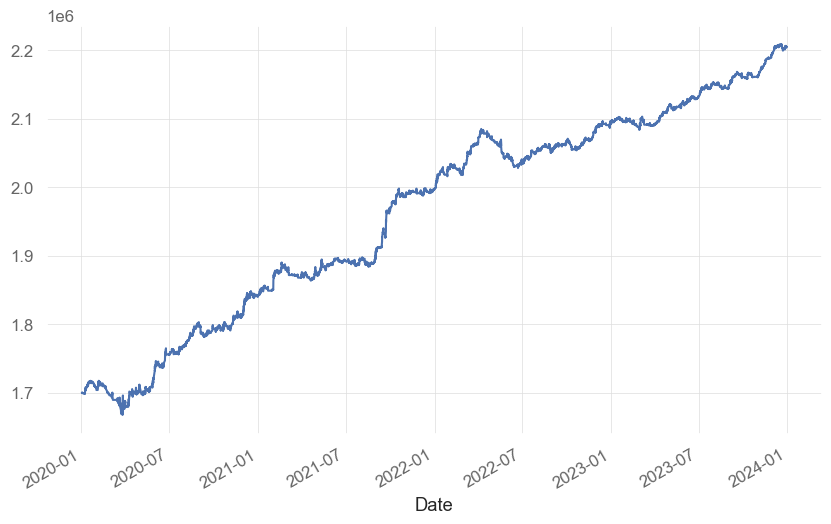

In [277]:

# Filter columns for position and return
position_columns = [col for col in combined_df.columns if 'position' in col]
return_columns = [col for col in combined_df.columns if '_ret' in col]

# Calculate the sum of returns for assets where position is non-zero
combined_df['sum_of_rturns'] = combined_df[return_columns].sum(axis=1)

# Count the number of non-zero positions for each row
combined_df['non_zero_positions'] = combined_df[position_columns].apply(lambda x: (x!=0).sum(), axis=1)

symbol_Equity = (combined_df[return_columns]*100000)


total_profit_from_returns = symbol_Equity.cumsum().iloc[-1]

Portfolio_EC = len(return_columns)*100000+(symbol_Equity.sum(axis=1).cumsum())

Portfolio_EC.plot()


In [ ]:
Portfolio_EC

In [ ]:
daily_change = Portfolio_EC.resample('D').last().diff()

In [ ]:
# Group by day and calculate daily max and min
daily_max =Portfolio_EC.resample('D').max()
daily_min = Portfolio_EC.resample('D').min()
# Calculate the range for each day
daily_range = daily_max - daily_min

# Calculate the average of these ranges
average_range = daily_range.mean()
daily_range.plot()

In [ ]:
Portfolio_EC_nifty = pd.concat([Portfolio_EC , ind_df['indClose']] , axis=1)


In [ ]:
Portfolio_EC_nifty.rename(columns={0:'EC'} , inplace=True)

In [ ]:
# Group by day and calculate the change from the start of the day
Portfolio_EC_nifty['nifty_change_from_open'] = Portfolio_EC_nifty.groupby(Portfolio_EC_nifty.index.date)['indClose'].transform(lambda x: x - x.iloc[0])
Portfolio_EC_nifty['EC_change_from_open'] = Portfolio_EC_nifty.groupby(Portfolio_EC_nifty.index.date)['EC'].transform(lambda x: x - x.iloc[0])


In [ ]:
Portfolio_EC_nifty.iloc[0:50]

In [ ]:
# Now, for simplicity, let's assume we're looking at any point in the day where Nifty is ±50 from the open
# We create a mask where this condition is true
mask = Portfolio_EC_nifty['nifty_change_from_open'].abs() >= 50

# Filtered DataFrame where the condition is met
filtered_df = Portfolio_EC_nifty[mask]

# At this point, `filtered_df` contains moments when Nifty changed by ±50 from the open, and corresponding EC changes

# If you want to visualize this for a specific day, you can:
import matplotlib.pyplot as plt

# Example: Plotting for the first available day in filtered_df
#example_date = filtered_df.index.date[0]
example_data = filtered_df[filtered_df.index.date == datetime.date()]

plt.figure(figsize=(14, 7))
plt.subplot(2, 1, 1)
plt.plot(example_data.index, example_data['indClose'], label='Nifty')
plt.title('Nifty Close')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(example_data.index, example_data['EC'], label='Portfolio EC', color='orange')
plt.title('Portfolio EC')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:

#=== pnl and stats

all_trades['pnl'] = np.where(all_trades['Side']=='Short' , all_trades['entry_price'] - all_trades['exit_price'] , all_trades['exit_price'] - all_trades['entry_price'] )
all_trades = all_trades.sort_values(by='entry_time')

long_trades = all_trades[all_trades['Side']=='long']
losers = all_trades[all_trades['exit_price']<all_trades['entry_price']]
losers['loss_perc'] = (losers['exit_price']/losers['entry_price'])-1
print("\n Mean losing trade: " , losers['loss_perc'].mean())
print("\n Largest loss: " , losers['loss_perc'].min())

In [ ]:


losers.sort_values(by='loss_perc').iloc[0:50]

In [ ]:
all_trades.tail(40)

In [ ]:

trade_file = log_path


und_fol = df_folder

symbol_to_view1 = "LTIM"

symbol_to_view = "_"+str(symbol_to_view1)+".csv"

trade_file = os.path.join(trade_file  , symbol_to_view)
print(trade_file)


symbol = symbol_to_view1+'.csv'
OHLC_file = os.path.join(und_fol ,symbol )


if (os.path.exists(trade_file) & os.path.exists(OHLC_file)):

    #2022-10-06
    plot_signal2_equity_from_file(tradelog_file=trade_file , unddf_file=OHLC_file , signal_date=datetime.date(2022 , 11 , 24) , stk=symbol_to_view1)


In [ ]:
top_2_ranks

In [ ]:
ind_df

In [ ]:
daily_ind = resample_data(ind_df ,  highcol = 'indHigh' , lowcol = 'indLow' , closecol = 'indClose' ,opencol = 'indOpen'  , volcol = 'Volume' , timeframe = '1D') 

In [ ]:
 #----- candle lenght and candle related functions

def candle_patterns(df , prefix=''):    
    
    df[f'{prefix}body'] = df[f'{prefix}Close'] - df[f'{prefix}Open']
    df[f'{prefix}body_abs'] = df[f'{prefix}body'].abs()
    prev_body = df[f'{prefix}body'].shift(1)
    prev_open = df[f'{prefix}Open'].shift(1)
    prev_close = df[f'{prefix}Close'].shift(1)
    
    prev_low = df[f'{prefix}Low'].shift(1)
    prev_prev_low = df[f'{prefix}Low'].shift(2)
    
    prev_high = df[f'{prefix}High'].shift(1)
    prev_prev_high = df[f'{prefix}High'].shift(2)
    
    
    
    # Calculate the rolling average of the body size for the last 1 hour
    df[f'{prefix}body_avg_1h'] = df[f'{prefix}body'].rolling(window=10).mean()

    # Create a boolean column that is True for negative candles
    df[f'{prefix}negative_candle'] = df[f'{prefix}body'] < 0

    df[f'{prefix}positive_candle'] = df[f'{prefix}body'] > 0

    # Calculate the rolling average of the absolute body size for the last 1 hour
    df[f'{prefix}body_avg_1h'] = df[f'{prefix}body'].abs().rolling(window=10).mean()

    # Check if the current negative candle's body is more than twice the average of the last 1 hour
    df[f'{prefix}bigrise'] = (df[f'{prefix}positive_candle']) & (df[f'{prefix}body'].abs() > 1.5 * df[f'{prefix}body_avg_1h'])
    df[f'{prefix}bigfall'] = (df[f'{prefix}negative_candle']) & (df[f'{prefix}body'].abs() > 1.5 * df[f'{prefix}body_avg_1h'])
    
    
    # Check if the past two lows are almost similar
    # Using 0.025% as the threshold
    almost_similar_lows = abs(prev_low - prev_prev_low) <= 0.00025 * prev_prev_low

    
    
    
    
    #=== Bullisj engulfing
    df[f'{prefix}bullish_engulfing'] = (
        (df[f'{prefix}body'] > 0) & (prev_body < 0) &
        (df[f'{prefix}body'] > prev_body.abs()) & 
        (df[f'{prefix}Open'] < prev_close) &
        (df[f'{prefix}Close'] > prev_open)
    )
    
    df[f'{prefix}bearish_engulfing'] = (
        (df[f'{prefix}body'] < 0) & (prev_body > 0) &
        (df[f'{prefix}body'] > prev_body.abs()) & 
        (df[f'{prefix}Open'] > prev_close) &
        (df[f'{prefix}Close'] < prev_low)
    )
    
    # Passt 2 rows same and this one is bullish
    df[f'{prefix}similar_lows_bullish'] = almost_similar_lows & df[f'{prefix}positive_candle']
    
    #== code strong bullish reversal
    #==== this is previous candle is bearish and this is big bullish candle and closes beyond high of previous candle
      
    
    df[f'{prefix}bullish_reversal'] = ( (prev_body <0) & (df[f'{prefix}body'] > 0) & (df[f'{prefix}body'] > prev_body.abs()*1.25) & (df[f'{prefix}Close'] > prev_high) & (df[f'{prefix}body']>df[f'{prefix}body_avg_1h'] ))
    df[f'{prefix}big_bear'] = ((df[f'{prefix}body'] > 0) & (df[f'{prefix}body']>df[f'{prefix}body_avg_1h']*2.5 ))
    
    return df
    
    
    
    
    

In [ ]:
daily_ind = candle_patterns(daily_ind)

In [ ]:
daily_ind[daily_ind['bearish_engulfing']==True]

In [ ]:

import mplfinance as mpf 
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

#print(option_df_temp)


# fig = plt.figure(figsize=(12, 8))

# # create GridSpec with 2 rows and 2 columns
# gs = gridspec.GridSpec(2, 2, figure=fig)
# # Create my own `marketcolors` style:
# mc = mpf.make_marketcolors(up='b', down='r')
# s = mpf.make_mpf_style(base_mpl_style='bmh', marketcolors=mc)

# t = fig.add_subplot(gs[0, i])
# t.grid(True, color='darkgrey')
mpf.plot(daily_ind[daily_ind.index.date==2022],style=s,type='candle',axtitle="Trade")
plt.tight_layout()
plt.show()



In [ ]:
daily_ind[daily_ind.index.year>=2022]

In [ ]:
# -*- coding: utf-8 -*-
#read_all_files_USA



import re
import os
import quantstats as qs
import time

import matplotlib.pyplot as plt

import nest_asyncio # install this package to avoid running in loop

import urllib

qs.extend_pandas()




pth = rC:\Users\Administrator\Downloads\DATA (1)\DATA\NF_200\NF_200_1min\big_data


ofol = r"C:\Users\Administrator\Desktop\Data\US_SP_500_15min_parquet"

count = 0 
cdf = pd.DataFrame()
if(os.path.exists(pth)):
    
    for fl in glob.glob(pth+ "/*.csv")[268:]:
            
            ddf = pd.DataFrame()
            count = count +1
            fname = os.path.basename(fl).split('.')[0]
            
            print( "\n Processing ", fname)
            
            df = pd.read_csv(fl)
            
            if 'timeutc' in df.columns:
                
               df.drop(columns='timeutc' , inplace=True)
            
            
            df['timestamp1'] = pd.to_datetime(df['timestamp1'] , format= "%Y-%m-%d %H:%M:%S" , errors='raise')
            
            df.set_index('timestamp1' , inplace=True)


            df = df[(df.index.year>=2014) & (df.index.year<2023)]                
            df = df[(df.index.dayofweek<5)]
            
            ddf['Close'] = df.close.resample('15Min').last().dropna()
            ddf['High'] = df.high.resample('15Min').max().dropna()
            ddf['Low'] = df.low.resample('15Min').min().dropna()
            ddf['Open'] = df.open.resample('15Min').first().dropna()
            ddf['Volume'] = df.volume.resample('15Min').sum().dropna()
            
            
            ofil = os.path.join(ofol , str(fname)+'.parquet')
            
            
            ddf.to_parquet(ofil, compression='Snappy')
            
            #ddf.to_csv(r"C:\Users\Administrator\Desktop\Data\US_SP_500_15min_parquet\A.csv")
            
            #cdf = pd.concat([cdf , ddf] , join='outer' , axis=1)
            
    
 
